# Project Segmentation:

### Group 10
    Francisco Costa, 20181393
    João Gouveia, 20181399
    Nuno Rocha, 20181407
    Pedro Rivera, 20181411

<a class="anchor" id="Table_Contents"></a>
# TABLE OF CONTENTS
<br></br>
* [# 1. Business Understanding](#business-understanding)


* [# 2. Data Understanding](#data-understanding)
    * [2.1: Collect the data](#collect-the-data)
    
    * [2.2: Describe the data](#describe-the-data)
    
    * [2.3: Explore the data](#explore-the-data)
        * [2.3.1: Demographics](#demographics)   
            * [Key Insights](#demographics-ki)
        * [2.3.2: Others](#others)   
            * [Key Insights](#others-ki)    

    * [2.4: Verify the data quality](#verify-data-quality)
        * [Key Insights](#dataquality-ki) 

* [# 3. Data Preparation](#data-preparation)
    * [3.1: Clean the data](#clean-the-data)
        * [3.1.1: Remove outliers](#outliers)

    * [3.2: Transform the data](#transform-the-data)
        * [3.2.1: Transformations to archieve "normality"](#transform-normality)
        * [3.2.2: Create flag variables](#flag-variables)
        * [3.2.3: Normalize the data](#normalize-the-data)

* [# 3. Modelling](#modelling)
    * [4.1: Clustering by k-means](#k_means)
        * [4.1.1: Product Usage segmentation](#k_means_productusage)
            * [Key Insights 1](#k_means_productusage-ki1)
            * [Key Insights 2](#k_means_productusage-ki2)
        * [4.1.1: Customer Value segmentation](#k_means_customervalue)
            * [Key Insights](#k_means_customervalue-ki)
            
    * [4.2: Final Remarks](#remarks)

<a class="anchor" id="business-understanding"></a>
# 1. Business Understanding 

Objective: The objective is to identify actionable segments within the Great Library Company's customer base considering the following 2 perspectives:

- The product usage segmentation
- The customer value segmentation

<a class="anchor" id="data-understanding"></a>
# 2. Data Understanding

In [1]:
# Import the required libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt

# Set the style for the Seaborn's plots
sns.set_style('whitegrid',{
    'xtick.bottom': True,
    'xtick.color': '.1',
    'xtick.direction': 'out',
    'xtick.top': False,
    'xtick.major.size': 1,
    'xtick.minor.size': 0.5,
    'ytick.left': True,
    'ytick.color': '.1',
    'ytick.direction': 'out',
    'ytick.right': False,
    'ytick.major.size': 1,
    'ytick.minor.size': 0.5,    
    'ytick.color': '.1',
    'grid.linestyle': '--',
    'axes.edgecolor': '.1',
    'grid.color': '0.8'
 })

In [2]:
# Define some helpful variables for the plots
# Boxplot
boxprops = dict(alpha = 0.85, linewidth = 1.0)
whiskerprops = dict(color = 'black', linewidth = 1.0, linestyle = '--')
capprops = dict(color = 'red', linewidth = 2.0)
medianprops = dict(color = 'red', linewidth = 1.0)
flierprops = dict(color = 'black', markeredgecolor = 'black', markerfacecolor = 'white',\
                              linewidth = 0.5, markersize = 4.0, marker = 'd')
whis = 3.0

# Define some helful functions for the plots
def f_find_nearest_Lmax(var_in, threshold_in):
    """This function determines the closest observation to a certain input threshold for the whisker higher limit """
    
    var = var_in.sort_values(ascending = False)
    if(threshold_in >= var.iloc[0]):
        return var.iloc[0]
    else:
        idx = (var - threshold_in).le(0).idxmax()
        return var_in[idx]

def f_find_nearest_Lmin(var_in, threshold_in):
    """This function determines the closest observation to a certain input threshold for the whisker lower limit """
    
    var = var_in.sort_values(ascending = True)
    if(threshold_in <= var.iloc[0]):
        return var.iloc[0]
    else:
        idx = (threshold_in - var).le(0).idxmax()
        return var_in[idx]

def f_stats_boxplot(var_in):
    """This function determines the statistics that are typically represented on a box plot."""

    median = var_in.median()
    IQR = sp.stats.iqr(var_in)
    Q1 = np.percentile(var_in, 25)
    Q3 = np.percentile(var_in, 75)
    lim1 = f_find_nearest_Lmin(var_in, Q1 - whis * IQR)
    lim2 = f_find_nearest_Lmax(var_in, Q3 + whis * IQR)
    skew = sp.stats.skew(var_in) 
    return (IQR, lim1, Q1, median, Q3, lim2, skew)

def f_pielabels_perc(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%)."""
    
    absolute = int(pct / 100 * np.sum(allvalues))
    return '{:.1f}%'.format(pct, absolute)

def f_pielabels(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%, value)."""
    
    absolute = int(pct / 100 * np.sum(allvalues))
    return '{:.1f}%\n({:.0f})'.format(pct, absolute)

def f_pielabels_M(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%, value in M)."""
    
    absolute = int(pct / 100 * np.sum(allvalues))
    return '{:.1f}%\n({:.1f}M)'.format(pct, absolute / 1e6)

def f_pielabels_k(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%, value in k)."""
    
    absolute = int(pct / 100. * np.sum(allvalues))
    return '{:.1f}%\n({:.1f}k)'.format(pct, absolute / 1000)

In [3]:
#---------------------------------------------------------------------------------------------------------------------
# Fig: Demographics Analysis
#---------------------------------------------------------------------------------------------------------------------
def f_demographics_analysis(df_in):
    figDemographics = plt.figure(figsize = (10, 16), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsDemographics = gridspec.GridSpec(nrows = 3, ncols = 2, hspace = .25, wspace = .2,\
                        height_ratios = [1, .8, .8], width_ratios = [1, 1], figure = figDemographics)


    # --------: Boxplot + Histogram for Age
    sgsDemographicsAge_00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsDemographics[0, 0],\
                                       hspace = .05, wspace = .2, height_ratios = (.15, .85))
    # boxplot
    axDemographicsAge_00 = plt.Subplot(figDemographics, sgsDemographicsAge_00[0, 0])
    figDemographics.add_subplot(axDemographicsAge_00, sharex = True)

    sns.boxplot(df_in['Age'], color = 'white', boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axDemographicsAge_00).set_title('Age', size = 14)
    
    axDemographicsAge_00.tick_params(labelbottom = False) 
    axDemographicsAge_00.set_xlabel('')

    stats = f_stats_boxplot(df_in['Age'])
    axDemographicsAge_00.text(stats[1], -.25, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
    axDemographicsAge_00.text(stats[2] - 0.15 * stats[0], .4, '{:.1f}'.format(stats[2]), color = 'black',\
                              ha = 'center')
    axDemographicsAge_00.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
    axDemographicsAge_00.text(stats[4] + 0.15 * stats[0], .4, '{:.1f}'.format(stats[4]), color = 'black',\
                              ha = 'center')
    axDemographicsAge_00.text(stats[5], -.25, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

    # histogram
    axDemographicsAge_10 = plt.Subplot(figDemographics, sgsDemographicsAge_00[1, 0])
    figDemographics.add_subplot(axDemographicsAge_10)

    sns.distplot(df_in['Age'], kde = False, rug = False, bins = 15,\
                     color = '#03366f', hist_kws = {'alpha': .85}, ax = axDemographicsAge_10)

    axDemographicsAge_10.set_xlabel('Age')
    axDemographicsAge_10.text(20, -50, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center',\
                              fontsize = 10)
    axDemographicsAge_10.set_ylabel('Customer Counts')
    axDemographicsAge_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axDemographicsAge_10.set_ylim((0, 450))


    # --------: Boxplot + Histogram for Income
    sgsDemographicsIncome_00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsDemographics[0, 1],\
                                                hspace = .05, wspace = .2, height_ratios = (.15, .85))
    # boxplot
    axDemographicsIncome_00 = plt.Subplot(figDemographics, sgsDemographicsIncome_00[0, 0])
    figDemographics.add_subplot(axDemographicsIncome_00, sharex = True)

    sns.boxplot(df_in['Income'], color = 'white', boxprops = boxprops, whiskerprops = whiskerprops,\
                capprops = capprops, medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axDemographicsIncome_00).set_title('Income', size = 14)

    axDemographicsIncome_00.tick_params(labelbottom = False) 
    axDemographicsIncome_00.set_xlabel('')

    stats = f_stats_boxplot(df_in['Income'])
    axDemographicsIncome_00.text(stats[1], -.25, '{:.1f}k'.format(stats[1] / 1000), color = 'red', ha = 'center')
    axDemographicsIncome_00.text(stats[2] - 0.28 * stats[0], .4, '{:.1f}k'.format(stats[2] / 1000), color = 'black',\
                                 ha = 'center')
    axDemographicsIncome_00.text(stats[3], .1, '{:.1f}k'.format(stats[3] / 1000), color = 'black', ha = 'center')
    axDemographicsIncome_00.text(stats[4] + 0.28 * stats[0], .4, '{:.1f}k'.format(stats[4] / 1000), color = 'black',\
                                 ha = 'center')
    axDemographicsIncome_00.text(stats[5], -.25, '{:.1f}k'.format(stats[5] / 1000), color = 'red', ha = 'center')

    # histogram
    axDemographicsIncome_10 = plt.Subplot(figDemographics, sgsDemographicsIncome_00[1, 0])
    figDemographics.add_subplot(axDemographicsIncome_10)

    sns.distplot(df_in['Income'], kde = False, rug = False, bins = 15,\
                     color = '#4ec5b0', hist_kws = {'alpha': 0.85}, ax = axDemographicsIncome_10)

    axDemographicsIncome_10.set_xlabel('Income')
    axDemographicsIncome_10.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                                                                                pos: '{:.0f}k'.format(x / 1000)))
    axDemographicsIncome_10.text(20, -50, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center',\
                                 fontsize = 10)
    axDemographicsIncome_10.set_ylabel('Customer Counts')
    axDemographicsIncome_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axDemographicsIncome_10.set_ylim((0, 450))

    
    # --------: Barplot for Education
    axDemographicsEducation_10 = plt.Subplot(figDemographics, gsDemographics[1, 0])
    figDemographics.add_subplot(axDemographicsEducation_10)

    educlevels_values = df_in.groupby(['Education'])['Custid'].count()
    educlevels = pd.Series(educlevels_values, index = educlevels_index, name = 'EducationLevels')
    palette = sns.color_palette(educlevels_colors)

    sns.barplot(x = educlevels.index, y = educlevels, palette = palette, ax = axDemographicsEducation_10)\
    .set_title('Education', size = 14)
    axDemographicsEducation_10.set_ylabel('Customer Counts')
    axDemographicsEducation_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axDemographicsEducation_10.set_ylim((0, 1350))
    axDemographicsEducation_10.set_xlabel('')
    pos = 0
    total = educlevels.sum()
    for index, value in educlevels.iteritems():
        axDemographicsEducation_10.text(pos, value, '{:.1f}%'.format(value / total * 100), color = 'black',\
                                        ha = 'center')
        pos = pos + 1

 
    # --------: Scatterplot of the Education with Income
    axDemographicsEducIncome_11 = plt.Subplot(figDemographics, gsDemographics[1, 1])  
    figDemographics.add_subplot(axDemographicsEducIncome_11)

    sns.swarmplot(x = 'Education', y = 'Income', data = df_in, palette = palette, order = educlevels_index,\
                  ax = axDemographicsEducIncome_11)\
    .set_title('Education vs Income', size = 14)
    
    axDemographicsEducIncome_11.set_xlabel('')
    axDemographicsEducIncome_11.set_ylabel('Income')
    axDemographicsEducIncome_11.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axDemographicsEducIncome_11.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y,\
                                                                                    pos: '{:.0f}k'.format(y / 1000)))

    # -------- Fig 1.5: Barplot for Marital_Status  
    axDemographicsMStatus_20 = plt.Subplot(figDemographics, gsDemographics[2, 0])  
    figDemographics.add_subplot(axDemographicsMStatus_20)

    mstatus_values = df_in.groupby(['Marital_Status'])['Custid'].count()
    mstatus = pd.Series(mstatus_values, index = mstatus_index, name = 'MaritalStatus')
    palette = sns.color_palette(mstatus_colors)

    sns.barplot(x = mstatus.index, y = mstatus, palette = palette, ax = axDemographicsMStatus_20)\
    .set_title('Marital_Status', size = 14)
    axDemographicsMStatus_20.set_ylabel('Customer Counts')
    axDemographicsMStatus_20.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axDemographicsMStatus_20.set_ylim((0, 1350))
    pos = 0
    total = mstatus.sum()
    for index, value in mstatus.iteritems():
        axDemographicsMStatus_20.text(pos, value, '{:.1f}%'.format(value / total * 100), color = 'black',\
                                      ha = 'center')
        pos = pos + 1


    # -------- Fig 1.6: Heatmap for customers count depending on the number of Teens/Kids at home
    axDemographicsTeensKids_21 = plt.Subplot(figDemographics, gsDemographics[2, 1])
    figDemographics.add_subplot(axDemographicsTeensKids_21)

    sns.heatmap(df_teenKids,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = 0, vmax = df_teenKids.values.max(),\
                linewidths = .5, cbar_kws = {'shrink': .75, 'label': 'Customer Counts'},\
                ax = axDemographicsTeensKids_21).set_title('Kidhome vs Teenhome', size = 14)

    axDemographicsTeensKids_21.invert_yaxis()
    axDemographicsTeensKids_21.set_xlabel('Kidhome')
    axDemographicsTeensKids_21.set_ylabel('Teenhome')
    axDemographicsTeensKids_21.set_aspect('equal')    
    
    return figDemographics
#---------------------------------------------------------------------------------------------------------------------
# Fig: MntTotal for Customer Demographics
#---------------------------------------------------------------------------------------------------------------------
def f_exploratory_MntTotalDemographics(df_in):
    figMntTotalDemographics = plt.figure(figsize = (14, 10), dpi = 80, facecolor = 'w',\
                                         edgecolor = 'k', constrained_layout = False)
    gsMntTotalDemographics = gridspec.GridSpec(nrows = 2, ncols = 2, hspace = .3, wspace = .2,\
                            height_ratios = [1, .85], width_ratios = [1, 1], figure = figMntTotalDemographics)

    # --------: Boxplot of the Total Expenditure per Age
    axMntTotalDemographics_00 = plt.Subplot(figMntTotalDemographics, gsMntTotalDemographics[0, 0])
    figMntTotalDemographics.add_subplot(axMntTotalDemographics_00)

    sns.boxplot(x = 'AgeBins', y = 'MntTotal', data = df_in, color = '#03366f',\
                boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axMntTotalDemographics_00).set_title('Total Expenditure vs Age', size = 14)

    pos = range(len(age_bucket_array))
    for tick, label in zip(pos, axMntTotalDemographics_00.get_xticklabels()):
        str_min = label.get_text().split(', ')[0]
        str_max = label.get_text().split(', ')[1]
        df_aux = df_in[df_in['AgeBins'] == pd.Interval(np.int(str_min[1:len(str_min)]),\
                                                       np.int(str_max[0:len(str_max)-1]), closed = 'right')]
        stats = f_stats_boxplot(df_aux['MntTotal'])
        axMntTotalDemographics_00.text(pos[tick], stats[1] - 1000, '{:.1f}k'.format(stats[1] / 1000),\
                                       color = 'red', ha = 'center')
        axMntTotalDemographics_00.text(pos[tick], stats[3] + 200, '{:.1f}k'.format(stats[3] / 1000),\
                                       color = 'white', ha = 'center')
        axMntTotalDemographics_00.text(pos[tick], stats[5] + 300, '{:.1f}k'.format(stats[5] / 1000),\
                                       color = 'red', ha = 'center')    

    axMntTotalDemographics_00.set_xlabel('Age')
    plt.setp(axMntTotalDemographics_00.get_xticklabels(), **{'rotation': 45})
    axMntTotalDemographics_00.set_ylabel('MntTotal')
    axMntTotalDemographics_00.set_ylim((-1500, 35000))
    axMntTotalDemographics_00.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axMntTotalDemographics_00.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y,\
                                                                                  pos: '{:.0f}k'.format(y / 1000)))   

    # --------: Scatter plot of the Total Expenditure with Income
    axMntTotalDemographics_01 = plt.Subplot(figMntTotalDemographics, gsMntTotalDemographics[0, 1])
    figMntTotalDemographics.add_subplot(axMntTotalDemographics_01)

    sns.scatterplot(x = 'Income', y = 'MntTotal', data = df_in,\
                    edgecolor = 'black', linewidth = .3, color = '#4ec5b0', marker = 'o', s = 20,
                    ax = axMntTotalDemographics_01).set_title('Total Expenditure vs Income', size = 14)

    axMntTotalDemographics_01.set_xlabel('Income')
    axMntTotalDemographics_01.get_xaxis().set_minor_locator(mtick.AutoMinorLocator())
    axMntTotalDemographics_01.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                                                                                  pos: '{:.0f}k'.format(x / 1000)))
    axMntTotalDemographics_01.set_ylabel('MntTotal')
    axMntTotalDemographics_01.set_ylim((-1500, 35000))
    axMntTotalDemographics_01.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axMntTotalDemographics_01.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y,\
                                                                                  pos: '{:.0f}k'.format(y / 1000)))

    # Plot line Y=x
    x_lim = axMntTotalDemographics_01.get_xlim()[1]
    y_lim = axMntTotalDemographics_01.get_ylim()[1]
    axMntTotalDemographics_01.plot((0, min(x_lim, y_lim)), (0, min(x_lim, y_lim)),\
                                   color = 'red', alpha = 0.75, zorder = 0)
    #Plot line Y=0
    axMntTotalDemographics_01.plot((0, x_lim), (0, 0), color = 'red', alpha = 0.75, zorder = 0)


    # --------: Boxplot of the Total Expenditure per Education Level
    axMntTotalDemographics_10 = plt.Subplot(figMntTotalDemographics, gsMntTotalDemographics[1, 0])
    figMntTotalDemographics.add_subplot(axMntTotalDemographics_10)

    palette = sns.color_palette(educlevels_colors)

    sns.boxplot(x = 'Education', y = 'MntTotal', data = df_in, order = educlevels_index, palette = palette,\
                boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axMntTotalDemographics_10).set_title('Total Expenditure vs Education', size = 14)

    pos = range(len(educlevels_index))
    for tick, label in zip(pos, axMntTotalDemographics_10.get_xticklabels()):
        df_aux = df_in[df_in['Education'] == label.get_text()]
        stats = f_stats_boxplot(df_aux['MntTotal'])
        axMntTotalDemographics_10.text(pos[tick], stats[1] - 1000, '{:.1f}k'.format(stats[1] / 1000),\
                                       color = 'red', ha = 'center')
        axMntTotalDemographics_10.text(pos[tick], stats[3] + 200, '{:.1f}k'.format(stats[3] / 1000),\
                                       color = 'black', ha = 'center')
        axMntTotalDemographics_10.text(pos[tick], stats[5] + 300, '{:.1f}k'.format(stats[5] / 1000),\
                                       color = 'red', ha = 'center')    

    axMntTotalDemographics_10.set_xlabel('Education')
    plt.setp(axMntTotalDemographics_10.get_xticklabels(), **{'rotation': 45})
    axMntTotalDemographics_10.set_ylabel('MntTotal')
    axMntTotalDemographics_10.set_ylim((-1500, 35000))
    axMntTotalDemographics_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axMntTotalDemographics_10.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y,\
                                                                                  pos: '{:.0f}k'.format(y / 1000)))


    # --------: Boxplot of the Total Expenditure per Marital Status
    axMntTotalDemographics_11 = plt.Subplot(figMntTotalDemographics, gsMntTotalDemographics[1, 1])
    figMntTotalDemographics.add_subplot(axMntTotalDemographics_11)
    
    palette = sns.color_palette(mstatus_colors)

    sns.boxplot(x = 'Marital_Status', y = 'MntTotal', data = df_in, order = mstatus_index, palette = palette,\
                boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axMntTotalDemographics_11).set_title('Total Expenditure vs Marital_Status', size = 14)

    pos = range(len(mstatus_index))
    for tick, label in zip(pos, axMntTotalDemographics_11.get_xticklabels()):
        df_aux = df_in[df_in['Marital_Status'] == label.get_text()]
        stats = f_stats_boxplot(df_aux['MntTotal'])
        axMntTotalDemographics_11.text(pos[tick], stats[1] - 1000, '{:.1f}k'.format(stats[1] / 1000),\
                                       color = 'red', ha = 'center')
        axMntTotalDemographics_11.text(pos[tick], stats[3] + 200, '{:.1f}k'.format(stats[3] / 1000),\
                                       color = 'black', ha = 'center')
        axMntTotalDemographics_11.text(pos[tick], stats[5] + 300, '{:.1f}k'.format(stats[5] / 1000),\
                                       color = 'red', ha = 'center')    

    axMntTotalDemographics_11.set_xlabel('Marital_Status')
    plt.setp(axMntTotalDemographics_11.get_xticklabels(), **{'rotation': 45})
    axMntTotalDemographics_11.set_ylabel('MntTotal')
    axMntTotalDemographics_11.set_ylim((-1500, 35000))
    axMntTotalDemographics_11.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axMntTotalDemographics_11.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y,\
                                                                                  pos: '{:.0f}k'.format(y / 1000)))
    
    return figMntTotalDemographics
#---------------------------------------------------------------------------------------------------------------------
# Fig: Product Usage
#---------------------------------------------------------------------------------------------------------------------
def f_exploratory_ProductUsage(df_in):
    figProductUsage = plt.figure(figsize = (16, 12), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsProductUsage = gridspec.GridSpec(nrows = 2, ncols = 6, hspace = .25, wspace = .3,\
                            height_ratios = [0.6, 1], width_ratios = [1, 1, 1, 1, 1, 1], figure = figProductUsage)

    # --------: Pie chart Amount spend by Product Usage
    axProductUsage_0 = plt.Subplot(figProductUsage, gsProductUsage[0, :])
    figProductUsage.add_subplot(axProductUsage_0)
    
    palette = sns.color_palette(Usage_colors)

    wedges, texts, autotexts = axProductUsage_0.pie(SpentbyUsage, radius = .9, startangle = 90,\
                                        autopct = lambda pct: f_pielabels_M(pct, SpentbyUsage),\
                                        pctdistance = 1.25, textprops = dict(color = 'black'),\
                                        colors = palette, wedgeprops = {'alpha': .85})
    axProductUsage_0.legend(wedges, SpentbyUsage.index.tolist(), title = 'Product Usage', loc = 'best',\
                bbox_to_anchor = (1, 0, .6, 1), prop = dict(size = 12))
    axProductUsage_0.set_title('Amount spent by Product Usage', size = 14)
    plt.setp(autotexts, size = 12, weight = 'bold')


    # --------: Boxplot + Histogram for each Product Usage
    for index, item in enumerate(list_Usage):
        sgsProductUsageBoxHist_1i = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsProductUsage[1, index],\
                                                         hspace = .05, wspace = .2, height_ratios = (.15, .85))

        # boxplot
        axProductUsageBoxHisti_00 = plt.Subplot(figProductUsage, sgsProductUsageBoxHist_1i[0, 0])
        figProductUsage.add_subplot(axProductUsageBoxHisti_00, sharex = True)

        sns.boxplot(eval('df_in[' + '\'' + item + '\'' + ']'), color = Usages_color_dict.get(item),\
                    boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                    medianprops = medianprops, flierprops = flierprops, whis = whis,\
                    ax = axProductUsageBoxHisti_00).set_title(item, size = 14)
        axProductUsageBoxHisti_00.tick_params(labelbottom = False) 
        axProductUsageBoxHisti_00.set_xlabel('')

        stats = f_stats_boxplot(eval('df_in[' + '\'' + item + '\'' + ']'))
        axProductUsageBoxHisti_00.text(stats[1], -.3, '{:.1f}k'.format(stats[1] / 1000), color = 'red', ha = 'center')
        if(index < 1):
            color = 'white'
        else:
            color = 'black'
        axProductUsageBoxHisti_00.text(stats[3], .1, '{:.1f}k'.format(stats[3] / 1000), color = color, ha = 'center')
        axProductUsageBoxHisti_00.text(stats[5], -.3, '{:.1f}k'.format(stats[5] / 1000), color = 'red', ha = 'center')

        # histogram
        axProductUsageBoxHisti_10 = plt.Subplot(figProductUsage, sgsProductUsageBoxHist_1i[1, 0])
        figProductUsage.add_subplot(axProductUsageBoxHisti_10)

        sns.distplot(eval('df_in[' + '\'' + item + '\'' + ']'), kde = False, rug = False, bins = 10,\
                         color = Usages_color_dict.get(item), hist_kws = {'alpha': .85},\
                     ax = axProductUsageBoxHisti_10)

        axProductUsageBoxHisti_10.set_xlabel('Amount Spent')
        axProductUsageBoxHisti_10.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                                                                                     pos: '{:.0f}k'.format(x / 1000)))
        axProductUsageBoxHisti_10.text(20, -250, 'skewness: ' + '{:.2f}'.format(stats[6]),\
                                      color = 'red', ha = 'center', fontsize = 10)
        axProductUsageBoxHisti_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axProductUsageBoxHisti_10.set_ylim((0, 1700))    
        if(index == 0):
            axProductUsageBoxHisti_10.set_ylabel('Customer Counts')  


    # --------: Boxplot + Histogram for HardCover books
    sgsProductUsageBoxHist_5 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsProductUsage[1, 5],\
                                                 hspace = .05, wspace = .2, height_ratios = (.15, .85))

    # boxplot
    axProductUsageBoxHist5_00 = plt.Subplot(figProductUsage, sgsProductUsageBoxHist_5[0, 0])
    figProductUsage.add_subplot(axProductUsageBoxHist5_00, sharex = True)

    sns.boxplot(df_in['MntHardcover'], color = '#d4ded0', boxprops = boxprops, whiskerprops = whiskerprops,\
                capprops = capprops, medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axProductUsageBoxHist5_00).set_title('MntHardcover', size = 14)
    axProductUsageBoxHist5_00.tick_params(labelbottom = False) 
    axProductUsageBoxHist5_00.set_xlabel('')

    stats = f_stats_boxplot(df_in['MntHardcover'])
    axProductUsageBoxHist5_00.text(stats[1], -.3, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
    axProductUsageBoxHist5_00.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
    axProductUsageBoxHist5_00.text(stats[5], -.3, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

    # histogram
    axProductUsageBoxHist5_10 = plt.Subplot(figProductUsage, sgsProductUsageBoxHist_5[1, 0])
    figProductUsage.add_subplot(axProductUsageBoxHist5_10)

    sns.distplot(df_in['MntHardcover'], kde = False, rug = False, bins = 15,\
                     color = '#d4ded0', hist_kws = {'alpha': .85}, ax = axProductUsageBoxHist5_10)

    axProductUsageBoxHist5_10.set_xlabel('Amount Spent')
    axProductUsageBoxHist5_10.text(20, -250, 'skewness: ' + '{:.2f}'.format(stats[6]),\
                                   color = 'red', ha = 'center', fontsize = 10)
    axProductUsageBoxHist5_10.text(120, 1620, 'total:' + \
           str(round(eval('df_in[[' + '\'' + 'MntHardcover' + '\'' + ']].sum()')[0] / 1e6, 3)) +\
                                   'M', color = 'black', ha = 'left')
    axProductUsageBoxHist5_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axProductUsageBoxHist5_10.set_ylim((0, 1700))
    
    return figProductUsage
#---------------------------------------------------------------------------------------------------------------------
# Fig: Channels
#---------------------------------------------------------------------------------------------------------------------
def f_exploratory_Channels(df_in):  
    figChannels = plt.figure(figsize = (16, 10), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    gsChannels = gridspec.GridSpec(nrows = 2, ncols = 4, hspace = .3, wspace = .3,\
                            height_ratios = [1, 1], width_ratios = [1, 1, 1, 1], figure = figChannels)

    # --------: Pie chart Amount spend by Channels
    axChannels_00 = plt.Subplot(figChannels, gsChannels[0, 0])
    figChannels.add_subplot(axChannels_00)

    palette = sns.color_palette(Channels_colors)

    wedges, texts, autotexts = axChannels_00.pie(SpentbyChannels, radius = .8, startangle = 90,\
                                        autopct = lambda pct: f_pielabels_k(pct, SpentbyChannels),\
                                        pctdistance = 1.4,\
                                        textprops = dict(color = 'black'),\
                                        colors = palette, wedgeprops = {'alpha': .85})
    axChannels_00.legend(wedges, SpentbyChannels.index.tolist(), title = 'Channels', loc = 'lower left',\
                bbox_to_anchor = (0, -.5, 0, 1), prop = dict(size = 12))
    axChannels_00.set_title('Purchases by Channels', size = 14)
    plt.setp(autotexts, size = 12, weight = 'bold')


    # --------: Boxplot + Histogram for each Channel
    for index, item in enumerate(list_Channels):
        sgsChannels_0i = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsChannels[0, index + 1],\
                                      hspace = .05, wspace = .2, height_ratios = (.15, .85))

        # boxplot
        axChannelsi_0i_00 = plt.Subplot(figChannels, sgsChannels_0i[0, 0])
        figChannels.add_subplot(axChannelsi_0i_00, sharex = True)

        sns.boxplot(eval('df_in[' + '\'' + item + '\'' + ']'), color = 'white',\
                    boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                    medianprops = medianprops, flierprops = flierprops, whis = whis,\
                    ax = axChannelsi_0i_00).set_title(item, size = 14)
        axChannelsi_0i_00.tick_params(labelbottom = False) 
        axChannelsi_0i_00.set_xlabel('')

        stats = f_stats_boxplot(eval('df_in[' + '\'' + item + '\'' + ']'))
        axChannelsi_0i_00.text(stats[1], -.3, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
        axChannelsi_0i_00.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
        axChannelsi_0i_00.text(stats[5], -.3, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

        # histogram
        axChannelsi_0i_10 = plt.Subplot(figChannels, sgsChannels_0i[1, 0])
        figChannels.add_subplot(axChannelsi_0i_10)

        sns.distplot(eval('df_in[' + '\'' + item + '\'' + ']'), kde = False, rug = False, bins = 10,\
                         color = Channels_color_dict.get(item), hist_kws = {'alpha': .85}, ax = axChannelsi_0i_10)

        axChannelsi_0i_10.set_xlabel('Purchases')
        axChannelsi_0i_10.text(2, -250, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red',\
                            ha = 'center', fontsize = 10)
        axChannelsi_0i_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axChannelsi_0i_10.set_ylim((0, 1200))    
        if(index == 0):
            axChannelsi_0i_10.set_ylabel('Customer Counts') 


    # --------: Pie chart Amount spend by Channels (including Deals)
    axChannels_10 = plt.Subplot(figChannels, gsChannels[1, 0])
    figChannels.add_subplot(axChannels_10)

    TotalPurchases_color_dict = Channels_color_dict
    TotalPurchases_color_dict.update({'NumDealsPurchases': '#660000'})
    TotalPurchases_colors = [TotalPurchases_color_dict.get(value) for value in TotalPurchases.index.tolist()]
    palette = sns.color_palette(TotalPurchases_colors)

    wedges, texts, autotexts = axChannels_10.pie(TotalPurchases, radius = .8, startangle = 90,\
                                        autopct = lambda pct: f_pielabels_k(pct, TotalPurchases),\
                                        pctdistance = 1.4, textprops = dict(color = 'black'),\
                                        colors = palette, wedgeprops = {'alpha': .85})
    axChannels_10.legend(wedges, TotalPurchases.index.tolist(), title = 'Channels', loc = 'lower left',\
                bbox_to_anchor = (0, -.6, 0, 1), prop = dict(size = 12))
    axChannels_10.set_title('Total Purchases', size = 14)
    plt.setp(autotexts, size = 12, weight = 'bold')


    # --------: Boxplot + Histogram for Deals
    sgsChannels_11 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsChannels[1, 1], hspace = .05,\
                                                      wspace = .2, height_ratios = (.15, .85))
    # boxplot
    axChannels_11_00 = plt.Subplot(figChannels, sgsChannels_11[0, 0])
    figChannels.add_subplot(axChannels_11_00, sharex = True)

    sns.boxplot(df_in['NumDealsPurchases'], color = 'white', boxprops = boxprops, whiskerprops = whiskerprops,\
                capprops = capprops, medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axChannels_11_00).set_title('NumDealsPurchases', size = 14)
    axChannels_11_00.tick_params(labelbottom = False) 
    axChannels_11_00.set_xlabel('')

    stats = f_stats_boxplot(df_in['NumDealsPurchases'])
    axChannels_11_00.text(stats[1], -.3, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
    axChannels_11_00.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
    axChannels_11_00.text(stats[5], -.3, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

    # histogram
    axChannels_11_10 = plt.Subplot(figChannels, sgsChannels_11[1, 0])
    figChannels.add_subplot(axChannels_11_10)

    sns.distplot(df_in['NumDealsPurchases'], kde = False, rug = False, bins = 15,\
                     color = '#660000', hist_kws = {'alpha': .85}, ax = axChannels_11_10)

    axChannels_11_10.set_xlabel('Purchases')
    axChannels_11_10.text(2, -250, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center',\
                          fontsize = 10)
    axChannels_11_10.set_ylabel('Customer Counts')
    axChannels_11_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())


    # --------: Scatterplot TotalPurchases vs Total Expenditure
    axChannels_12 = plt.Subplot(figChannels, gsChannels[1, 2:4])
    figChannels.add_subplot(axChannels_12)

    sns.scatterplot(x = 'TotalPurchases', y = 'MntTotal', data = df_in, size = 'NumDealsPurchases',\
                    hue = 'NumDealsPurchases', edgecolor = 'black', linewidth = .3, color = '#c3c388',\
                    marker = 'o', s = 20, ax = axChannels_12).\
    set_title('Total Expenditure vs TotalPurchases', size = 14)

    axChannels_12.set_xlabel('TotalPurchases')
    axChannels_12.get_xaxis().set_minor_locator(mtick.AutoMinorLocator())
    axChannels_12.set_ylabel('MntTotal')
    axChannels_12.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axChannels_12.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y, pos: '{:.0f}k'.format(y / 1000)))

    # Plot line X=0
    y_lim = axChannels_12.get_ylim()[1]
    axChannels_12.plot((0, 0), (0, y_lim), color = 'red', alpha = 0.75, zorder = 0)
    # Plot line Y=0
    x_lim = axChannels_12.get_xlim()[1]
    axChannels_12.plot((0, x_lim), (0, 0), color = 'red', alpha = 0.75, zorder = 0)
    
    return figChannels
#---------------------------------------------------------------------------------------------------------------------
# Fig: Total Purchases + Web
#---------------------------------------------------------------------------------------------------------------------
def f_exploratory_Purchases(df_in):  
    figPurchases = plt.figure(figsize = (16, 5), dpi = 80, facecolor = 'w', edgecolor = 'k', constrained_layout = False)
    gsPurchases = gridspec.GridSpec(nrows = 2, ncols = 3, hspace = .05, wspace = .2,\
                        height_ratios = [.15, .85], width_ratios = [.8, .8, 1], figure = figPurchases)

    # --------: Boxplot + Histogram for Total Purchases
    axPurchases_00_00 = plt.Subplot(figPurchases, gsPurchases[0, 0])
    figPurchases.add_subplot(axPurchases_00_00)

    sns.boxplot(df_in['TotalPurchases'], color = 'white', boxprops = boxprops, whiskerprops = whiskerprops,\
                capprops = capprops, medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axPurchases_00_00).set_title('Total Purchases', size = 14)
    axPurchases_00_00.tick_params(labelbottom = False) 
    axPurchases_00_00.set_xlabel('')

    stats = f_stats_boxplot(df_in['TotalPurchases'])
    axPurchases_00_00.text(stats[1], -.3, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
    axPurchases_00_00.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
    axPurchases_00_00.text(stats[5], -.3, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

    # histogram
    axPurchases_00_10 = plt.Subplot(figPurchases, gsPurchases[1, 0])
    figPurchases.add_subplot(axPurchases_00_10)

    sns.distplot(df_in['TotalPurchases'], kde = False, rug = False, bins = 15,\
                     color = '#c3c388', hist_kws = {'alpha': .85}, ax = axPurchases_00_10)

    axPurchases_00_10.set_xlabel('TotalPurchases')
    axPurchases_00_10.text(2, -50, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center',\
                           fontsize = 10)
    axPurchases_00_10.set_ylabel('Customer Counts')
    axPurchases_00_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())


    # --------: Boxplot + Histogram for Web site visits per month
    axPurchases_01_00 = plt.Subplot(figPurchases, gsPurchases[0, 1])
    figPurchases.add_subplot(axPurchases_01_00)

    sns.boxplot(df_in['NumWebVisitsMonth'], color = 'white', boxprops = boxprops, whiskerprops = whiskerprops,\
                capprops = capprops, medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axPurchases_01_00).set_title('NumWebVisitsMonth', size = 14)
    axPurchases_01_00.tick_params(labelbottom = False) 
    axPurchases_01_00.set_xlabel('')

    stats = f_stats_boxplot(df_in['NumWebVisitsMonth'])
    axPurchases_01_00.text(stats[1], -.3, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
    axPurchases_01_00.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
    axPurchases_01_00.text(stats[5], -.3, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

    # histogram
    axPurchases_01_10 = plt.Subplot(figPurchases, gsPurchases[1, 1])
    figPurchases.add_subplot(axPurchases_01_10)

    sns.distplot(df_in['NumWebVisitsMonth'], kde = False, rug = False, bins = 15,\
                     color = '#003fff', hist_kws = {'alpha': .85}, ax = axPurchases_01_10)

    axPurchases_01_10.set_xlabel('Number of Visits per Month')
    axPurchases_01_10.text(2, -100, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center',\
                           fontsize = 10)
    axPurchases_01_10.set_ylabel('Customer Counts')
    axPurchases_01_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())


    # --------: Scatter plot NumWebPurchases vs NumWebVisitsMonth
    axPurchases_02 = plt.Subplot(figPurchases, gsPurchases[:, 2])
    figPurchases.add_subplot(axPurchases_02, sharex = True)

    sns.scatterplot(x = 'NumWebVisitsMonth', y = 'NumWebPurchases', size = 'MntTotal', hue = 'MntTotal', data = df_in,\
                    sizes=(15, 150), palette = sns.dark_palette('blue', as_cmap = True, reverse = True),\
                    edgecolor = 'black', linewidth = 0, ax = axPurchases_02)\
    .set_title('NumWebPurchases vs NumWebVisitsMonth', size = 14)

    axPurchases_02.set_xlabel('Number of Visits per Month')
    axPurchases_02.get_xaxis().set_minor_locator(mtick.AutoMinorLocator())
    axPurchases_02.set_ylabel('Number of Web Purchases')
    axPurchases_02.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())

    # Plot line X=0 & Y >= 1
    y_lim = axPurchases_02.get_ylim()[1]
    axPurchases_02.plot((0, 0), (1, y_lim), color = 'red', alpha = 0.75, zorder = 0)

    return figPurchases
#---------------------------------------------------------------------------------------------------------------------
# Fig: Recency + Customer's Enrolment
#---------------------------------------------------------------------------------------------------------------------
def f_exploratory_Recency(df_in):    
    figRecency = plt.figure(figsize = (16, 5), dpi = 80, facecolor = 'w', edgecolor = 'k', constrained_layout = False)
    gsRecency = gridspec.GridSpec(nrows = 2, ncols = 3, hspace = .05, wspace = .2,\
                            height_ratios = [.15, .85], width_ratios = [1, 0.8, 1], figure = figRecency)

    # --------: Seasonal plot for Dt_Customer
    axRecency_00 = plt.Subplot(figRecency, gsRecency[:, 0])
    figRecency.add_subplot(axRecency_00)

    list_DtYears = [Year for Year in range (df_in['Dt_Customer'].dt.year.min(), df_in['Dt_Customer'].dt.year.max() + 1)]
    list_DtYears_colors = {list_DtYears[i]: sns.color_palette('YlGnBu', len(df_in['Dt_Customer'].dt.year.unique()))\
                           .as_hex()[i] for i in range(0, len(list_DtYears))}

    for Year in list_DtYears:
        sns.lineplot(x = eval('DtbyYearMonth.loc[(' + str(Year) + ')].index'),\
                     y = eval('DtbyYearMonth.loc[(' + str(Year) + ')].values'), 
                     color = list_DtYears_colors.get(Year), label = str(Year), ax = axRecency_00)

    axRecency_00.set_title('Dt_Customer Seasonality', size = 14)
    axRecency_00.set_xlabel('Month')
    axRecency_00.set_xlim((1, 12))
    axRecency_00.get_xaxis().set_major_locator(mtick.LinearLocator(12))
    axRecency_00.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axRecency_00.set_ylabel('Customer Counts')
    axRecency_00.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())


    # --------: Boxplot + Histogram for Recency
    axRecency_01 = plt.Subplot(figRecency, gsRecency[0, 1])
    figRecency.add_subplot(axRecency_01)

    sns.boxplot(df_in['Recency'], color = 'white', boxprops = boxprops, whiskerprops = whiskerprops,\
                capprops = capprops, medianprops = medianprops, flierprops = flierprops, whis = whis,\
                ax = axRecency_01).set_title('Recency', size = 14)
    axRecency_01.tick_params(labelbottom = False) 
    axRecency_01.set_xlabel('')

    stats = f_stats_boxplot(df_in['Recency'])
    axRecency_01.text(stats[1], -.3, '{:.1f}'.format(stats[1]), color = 'red', ha = 'center')
    axRecency_01.text(stats[3], .1, '{:.1f}'.format(stats[3]), color = 'black', ha = 'center')
    axRecency_01.text(stats[5], -.3, '{:.1f}'.format(stats[5]), color = 'red', ha = 'center')

    # histogram
    axRecency_11 = plt.Subplot(figRecency, gsRecency[1, 1])
    figRecency.add_subplot(axRecency_11)

    sns.distplot(df_in['Recency'], kde = False, rug = False, bins = 15,\
                     color = '#f15914', hist_kws = {'alpha': .85}, ax = axRecency_11)

    axRecency_11.set_xlabel('Days since last purchase')
    axRecency_11.text(2, -50, 'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center', fontsize = 10)
    axRecency_11.set_ylabel('Customer Counts')
    axRecency_11.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())


    # --------: Scatterplot Revenue vs Recency
    axRecency_12 = plt.Subplot(figRecency, gsRecency[:, 2])
    figRecency.add_subplot(axRecency_12)

    sns.scatterplot(x = 'Recency', y = 'MntTotal', data = df_in,\
                    edgecolor = 'black', linewidth = .3, color = '#4ec5b0', marker = 'o', s = 20, ax = axRecency_12).\
    set_title('Total Expenditure vs Recency', size = 14)

    axRecency_12.set_xlabel('Days since last purchase')
    axRecency_12.get_xaxis().set_minor_locator(mtick.AutoMinorLocator())
    axRecency_12.set_ylabel('Total Expenditure')
    axRecency_12.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axRecency_12.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y, pos: '{:.0f}k'.format(y / 1000)))
    
    return figRecency

In [4]:
#---------------------------------------------------------------------------------------------------------------------
# Fig: Transformation Boxplot + Histogram
#---------------------------------------------------------------------------------------------------------------------
def f_transformHist_analysis (df_in, varlist_in, colorlist_in, maxlist_in):
    n_plots = len(varlist_in)
    figTransformHist = plt.figure(figsize = (2.5 * n_plots, 6), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    gsTransformHisti = gridspec.GridSpec(nrows = 2, ncols = n_plots, hspace = .05, wspace = .25,\
                            height_ratios = [.15, .85], width_ratios = [1 for i in range(n_plots)],\
                                                                 figure = figTransformHist)

    for index, item in enumerate(varlist_in):
        # boxplot
        axTransformHisti_00 = plt.Subplot(figTransformHist, gsTransformHisti[0, index])
        figTransformHist.add_subplot(axTransformHisti_00, sharex = True)

        sns.boxplot(eval('df_in[' + '\'' + item  + '\'' + ']'), color = 'white',\
                    boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                    medianprops = medianprops, flierprops = flierprops, whis = whis,\
                    ax = axTransformHisti_00).set_title(item, size = 12)
        axTransformHisti_00.tick_params(labelbottom = False) 
        axTransformHisti_00.set_xlabel('')

        stats = f_stats_boxplot(eval('df_in[' + '\'' + item  + '\'' + ']'))
        axTransformHisti_00.text(stats[1], -.3, '{:.2f}'.format(stats[1]), color = 'red', ha = 'center')
        axTransformHisti_00.text(stats[3], .1, '{:.2f}'.format(stats[3]), color = 'black', ha = 'center')
        axTransformHisti_00.text(stats[5], -.3, '{:.2f}'.format(stats[5]), color = 'red', ha = 'center')

        # histogram
        axTransformHisti_10 = plt.Subplot(figTransformHist, gsTransformHisti[1, index])
        figTransformHist.add_subplot(axTransformHisti_10)

        sns.distplot(eval('df_in[' + '\'' + item  + '\'' + ']'), kde = False, rug = False, bins = 15,\
                         color = colorlist_in[index], hist_kws = {'alpha': .85}, ax = axTransformHisti_10)

        axTransformHisti_10.set_xlabel('Amount Spent')
        axTransformHisti_10.text(stats[3], -.2 * maxlist_in[index], 'skewness: ' + '{:.2f}'.format(stats[6]),\
                                 color = 'red', ha = 'center',\
                       fontsize = 10)
        axTransformHisti_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axTransformHisti_10.set_ylim((0, maxlist_in[index]))    
        if(index == 0):
            axTransformHisti_10.set_ylabel('Customer Counts')  

    return figTransformHist

In [5]:
#---------------------------------------------------------------------------------------------------------------------
# Fig: Cluster Analysis (for the variables used in the clustering method)
#---------------------------------------------------------------------------------------------------------------------
def f_cluster_analysis (vars_in, df_in, color_palette_in):
    axCluster = sns.pairplot(df_in, vars = vars_in, diag_kind = 'kde', diag_kws = dict(shade = True),\
                              hue = 'cluster', palette = color_palette_in)

    return axCluster
#---------------------------------------------------------------------------------------------------------------------
# Fig: Cluster interpretation (using all relevant variables)
#---------------------------------------------------------------------------------------------------------------------
def f_cluster_interpretation (n_clusters_in, df_in):
    figClusterInt = plt.figure(figsize = (16 / 6 * n_clusters_in, 85), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsClusterInt = gridspec.GridSpec(nrows = 19, ncols = n_clusters_in, hspace = .3, wspace = .3,\
                        height_ratios = [1 for i in range(19)], width_ratios = [1 for i in range(n_clusters_in)],\
                                       figure = figClusterInt)
    
    vmax = 0
    for cluster in range(n_clusters_in):
        for k in range(min_kids, max_kids + 1):
            for t in range(min_teens, max_teens + 1):
                aux = df_in[df_in['cluster'] == cluster]\
                .loc[(df['Kidhome'] == k) & (df['Teenhome'] == t), 'Custid'].count()
                if(aux > vmax):
                    vmax = aux

    for cluster in range(n_clusters_in):

        # -------- Figs: BoxPlot + Histogram for Age
        sgsClusterInt_Agei = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsClusterInt[0, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))

        # boxplot
        axClusterInt_Agei_00 = plt.Subplot(figClusterInt, sgsClusterInt_Agei[0, 0])
        figClusterInt.add_subplot(axClusterInt_Agei_00, sharex = True)
    
        sns.boxplot(df_in[df_in['cluster'] == cluster]['Age'],\
                    color = 'white',\
                    boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                    medianprops = medianprops, flierprops = flierprops, whis = whis,\
                    ax = axClusterInt_Agei_00)
        axClusterInt_Agei_00.tick_params(labelbottom = False) 
        axClusterInt_Agei_00.set_xlabel('')
        axClusterInt_Agei_00.set_xlim((15, 80))

        stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['Age'])
        axClusterInt_Agei_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]), color = 'red', ha = 'center')
        axClusterInt_Agei_00.text(stats[3], .1, '{:.0f}'.format(stats[3]), color = 'black', ha = 'center')
        axClusterInt_Agei_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]), color = 'red', ha = 'center')

        # histogram
        axClusterInt_Agei_10 = plt.Subplot(figClusterInt, sgsClusterInt_Agei[1, 0])
        figClusterInt.add_subplot(axClusterInt_Agei_10)

        sns.distplot(df_in[df_in['cluster'] == cluster]['Age'], kde = False, rug = False, bins = 7,\
                         color = '#03366f', hist_kws = {'alpha': .85}, ax = axClusterInt_Agei_10)

        axClusterInt_Agei_10.set_xlabel('Age')
        axClusterInt_Agei_10.set_xlim((15, 80))
        if(cluster == 0):
            axClusterInt_Agei_10.set_ylabel('Customer Counts')
        else:
            axClusterInt_Agei_10.set_ylabel('')
        axClusterInt_Agei_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axClusterInt_Agei_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True)) 

        # add cluster record counts
        cluster_nrecords = df_in[df_in['cluster'] == cluster]['Custid'].count()
        axClusterInt_Agei_00.set_title('Cluster ' + str(cluster) + '\n' + \
                                       'n = {:d} ({:.0f}%)'.format(cluster_nrecords,\
                                                           cluster_nrecords / df_in.shape[0] * 100), size = 14)
        
        
        # -------- Figs:BoxPlot + Histogram for Income
        sgsClusterInt_Incomei = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[1, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['Income'].sum() / df_in['Income'].sum() * 100

        # boxplot
        axClusterInt_Incomei_00 = plt.Subplot(figClusterInt, sgsClusterInt_Incomei[0, 0])
        figClusterInt.add_subplot(axClusterInt_Incomei_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['Income'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_Incomei_00)
            
            axClusterInt_Incomei_00.tick_params(labelbottom = False) 
            
            axClusterInt_Incomei_00.set_xlabel('')
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['Income'])
            axClusterInt_Incomei_00.text(stats[1], -.3, '{:.0f}k'.format(stats[1] / 1000),\
                                               color = 'red', ha = 'center')
            axClusterInt_Incomei_00.text(stats[3], .1, '{:.0f}k'.format(stats[3] / 1000),\
                                               color = 'black', ha = 'center')
            axClusterInt_Incomei_00.text(stats[5], -.3, '{:.0f}k'.format(stats[5] / 1000),\
                                               color = 'red', ha = 'center')
            if(stats[3] > 0.9 * max(df_in['Income'])):
                axClusterInt_Incomei_00.set_xlim((min(df_in[df_in['cluster'] == cluster]['Income']),\
                                                 max(df_in[df_in['cluster'] == cluster]['Income'])))
                axClusterInt_Incomei_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_Incomei_00.set_xlim((0, max(df_in['Income'])))
                axClusterInt_Incomei_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_Incomei_10 = plt.Subplot(figClusterInt, sgsClusterInt_Incomei[1, 0])
        figClusterInt.add_subplot(axClusterInt_Incomei_10)
                                  
        if(percent > 0):    
            if(stats[3] > 0.9 * max(df_in['Income'])):
                axClusterInt_Incomei_10.set_xlim((min(df_in[df_in['cluster'] == cluster]['Income']),\
                                                 max(df_in[df_in['cluster'] == cluster]['Income'])))
                axClusterInt_Incomei_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_Incomei_10.set_xlim((0, max(df_in['Income'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['Income'], kde = False, rug = False, bins = 7,\
                         color = '#4ec5b0', hist_kws = {'alpha': .85},\
                         ax = axClusterInt_Incomei_10)
                                  
            axClusterInt_Incomei_10.set_xlabel('Income')
            axClusterInt_Incomei_10.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                  pos: '{:.0f}k'.format(x / 1000)))
            if(cluster == 0):
                axClusterInt_Incomei_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_Incomei_10.set_ylabel('')
            axClusterInt_Incomei_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_Incomei_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True)) 
        
        
        # -------- Figs: Barplot for Education
        axClusterInt_Educationi = plt.Subplot(figClusterInt, gsClusterInt[2, cluster])
        figClusterInt.add_subplot(axClusterInt_Educationi)

        educlevels_values = df_in[df_in['cluster'] == cluster].groupby(['Education'])['Custid'].count()
        educlevels = pd.Series(educlevels_values, index = educlevels_index, name = 'EducationLevels')
        palette = sns.color_palette(educlevels_colors)

        sns.barplot(x = educlevels.index, y = educlevels, palette = palette, ax = axClusterInt_Educationi)
        if(cluster == 0):
            axClusterInt_Educationi.set_ylabel('Customer Counts')
        else:
            axClusterInt_Educationi.set_ylabel('')
            #axClusterInt_Educationi.tick_params(labelleft = False)  
        axClusterInt_Educationi.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axClusterInt_Educationi.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True)) 
        plt.setp(axClusterInt_Educationi.get_xticklabels(), **{'rotation': 60})
        pos = 0
        total = educlevels.sum()
        for index, value in educlevels.iteritems():
            if(value > 0):
                axClusterInt_Educationi.text(pos, value, '{:.0f}%'.format(value / total * 100),\
                                             color = 'black', ha = 'center')
            pos = pos + 1           
        
        
        
        # -------- Figs: Barplot for Marital_Status
        axClusterInt_MStatusi = plt.Subplot(figClusterInt, gsClusterInt[3, cluster])
        figClusterInt.add_subplot(axClusterInt_MStatusi)

        mstatus_values = df_in[df_in['cluster'] == cluster].groupby(['Marital_Status'])['Custid'].count()
        mstatus = pd.Series(mstatus_values, index = mstatus_index, name = 'MaritalStatus')
        palette = sns.color_palette(mstatus_colors)

        sns.barplot(x = mstatus.index, y = mstatus, palette = palette, ax = axClusterInt_MStatusi)
        if(cluster == 0):
            axClusterInt_MStatusi.set_ylabel('Customer Counts')
        else:
            axClusterInt_MStatusi.set_ylabel('')
        axClusterInt_MStatusi.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axClusterInt_MStatusi.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True)) 
        plt.setp(axClusterInt_MStatusi.get_xticklabels(), **{'rotation': 60})
        pos = 0
        total = mstatus.sum()
        for index, value in mstatus.iteritems():
            if(value > 0):
                axClusterInt_MStatusi.text(pos, value, '{:.0f}%'.format(value / total * 100),\
                                           color = 'black', ha = 'center')
            pos = pos + 1           
        
        
        
        # -------- Figs: Heatmap for customers count depending on the number of Teens/Kids at home
        df_teenKids_cluster = pd.DataFrame(np.zeros(shape = (max_kids + 1, max_teens + 1)))
        for k in range(min_kids, max_kids + 1):
            for t in range(min_teens, max_teens + 1):
                df_teenKids_cluster[k][t] = df_in[df_in['cluster'] == cluster]\
                .loc[(df['Kidhome'] == k) & (df['Teenhome'] == t), 'Custid'].count()
        

        if(cluster == n_clusters_in - 1):
            sgsClusterInt_teenKidsi = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = gsClusterInt[4, cluster],\
                                                                hspace = .05, wspace = .15, width_ratios = (1, .1))

            axClusterInt_teenKidsi_00 = plt.Subplot(figClusterInt, sgsClusterInt_teenKidsi[0, 0])
            figClusterInt.add_subplot(axClusterInt_teenKidsi_00, sharey = True)
            axClusterInt_teenKidsi_01 = plt.Subplot(figClusterInt, sgsClusterInt_teenKidsi[0, 1])
            figClusterInt.add_subplot(axClusterInt_teenKidsi_01, sharey = True)

            cbar_kws =  {'label': 'Customer Counts'}
            sns.heatmap(df_teenKids_cluster,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = 0,\
                        vmax = vmax , linewidths = .5, cbar_kws = cbar_kws,\
                        cbar = True, cbar_ax = axClusterInt_teenKidsi_01, ax = axClusterInt_teenKidsi_00)

            axClusterInt_teenKidsi_00.invert_yaxis()
            axClusterInt_teenKidsi_00.set_xlabel('Kidhome')
            axClusterInt_teenKidsi_00.set_aspect('equal') 
        else:
            axClusterInt_teenKidsi = plt.Subplot(figClusterInt, gsClusterInt[4, cluster])
            figClusterInt.add_subplot(axClusterInt_teenKidsi) 

            sns.heatmap(df_teenKids_cluster,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = 0,\
                        vmax = vmax , linewidths = .5, cbar = False, ax = axClusterInt_teenKidsi)        

            axClusterInt_teenKidsi.invert_yaxis()
            axClusterInt_teenKidsi.set_xlabel('Kidhome')
            axClusterInt_teenKidsi.set_aspect('equal')
        if(cluster == 0):
            axClusterInt_teenKidsi.set_ylabel('Teenhome')            
            

            
        # -------- Figs:BoxPlot + Histogram for MntTechnical
        sgsClusterInt_MntTechnicali = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                           subplot_spec = gsClusterInt[5, cluster],\
                                                hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntTechnical'].sum() / df_in['MntTechnical'].sum() * 100

        # boxplot
        axClusterInt_MntTechnicali_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntTechnicali[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntTechnicali_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntTechnical'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntTechnicali_00)
            
            axClusterInt_MntTechnicali_00.tick_params(labelbottom = False) 
            axClusterInt_MntTechnicali_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntTechnical'])           
            if(stats[5] <  0.1 * max(df_in['MntTechnical'])):
                axClusterInt_MntTechnicali_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntTechnicali_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                   color = 'black', ha = 'center')
                axClusterInt_MntTechnicali_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntTechnicali_00.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntTechnical'])))
                axClusterInt_MntTechnicali_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_MntTechnicali_00.text(stats[1], -.3, '{:.0f}k'.format(stats[1] / 1000),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntTechnicali_00.text(stats[3], .1, '{:.0f}k'.format(stats[3] / 1000),\
                                                   color = 'black', ha = 'center')
                axClusterInt_MntTechnicali_00.text(stats[5], -.3, '{:.0f}k'.format(stats[5] / 1000),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntTechnicali_00.set_xlim((0, max(df_in['MntTechnical'])))
                axClusterInt_MntTechnicali_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_MntTechnicali_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntTechnicali[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntTechnicali_10)
        if(percent > 0):
            if(stats[5] <  0.1 * max(df_in['MntTechnical'])):
                axClusterInt_MntTechnicali_10.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntTechnical'])))
                axClusterInt_MntTechnicali_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntTechnicali_10.set_xlim((0, max(df_in['MntTechnical'])))
                axClusterInt_MntTechnicali_10.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                                                                                  pos: '{:.0f}k'.format(x / 1000)))

            sns.distplot(df_in[df_in['cluster'] == cluster]['MntTechnical'], kde = False, rug = False, bins = 7,\
                         color = Usages_color_dict.get('MntTechnical'), hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntTechnicali_10)
            
            axClusterInt_MntTechnicali_10.set_xlabel('MntTechnical')
            if(cluster == 0):
                axClusterInt_MntTechnicali_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntTechnicali_10.set_ylabel('')
            axClusterInt_MntTechnicali_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntTechnicali_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True)) 

            

        # -------- Figs:BoxPlot + Histogram for MntRomance
        sgsClusterInt_MntRomancei = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsClusterInt[6, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntRomance'].sum() / df_in['MntRomance'].sum() * 100

        # boxplot
        axClusterInt_MntRomancei_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntRomancei[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntRomancei_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntRomance'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntRomancei_00)
            
            axClusterInt_MntRomancei_00.tick_params(labelbottom = False) 
            axClusterInt_MntRomancei_00.set_xlabel('')

            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntRomance'])
            if(stats[5] <  0.1 * max(df_in['MntRomance'])):
                axClusterInt_MntRomancei_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntRomancei_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                 color = 'black', ha = 'center')
                axClusterInt_MntRomancei_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntRomancei_00.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntRomance'])))
                axClusterInt_MntRomancei_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_MntRomancei_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntRomancei_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                 color = 'black', ha = 'center')
                axClusterInt_MntRomancei_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntRomancei_00.set_xlim((0, max(df_in['MntRomance'])))
                axClusterInt_MntRomancei_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_MntRomancei_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntRomancei[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntRomancei_10)
        
        if(percent > 0):
            if(stats[5] <  0.1 * max(df_in['MntRomance'])):
                axClusterInt_MntRomancei_10.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntRomance'])))
                axClusterInt_MntRomancei_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntRomancei_10.set_xlim((0, max(df_in['MntRomance'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['MntRomance'], kde = False, rug = False, bins = 7,\
                         color = Usages_color_dict.get('MntRomance'), hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntRomancei_10)
            
            axClusterInt_MntRomancei_10.set_xlabel('MntRomance')
            if(cluster == 0):
                axClusterInt_MntRomancei_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntRomancei_10.set_ylabel('')
            axClusterInt_MntRomancei_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntRomancei_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))
            
            
            
        # -------- Figs:BoxPlot + Histogram for MntAdventure
        sgsClusterInt_MntAdventurei = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsClusterInt[7, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntAdventure'].sum() / df_in['MntAdventure'].sum() * 100

        # boxplot
        axClusterInt_MntAdventurei_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntAdventurei[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntAdventurei_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntAdventure'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntAdventurei_00)
            
            axClusterInt_MntAdventurei_00.tick_params(labelbottom = False) 
            axClusterInt_MntAdventurei_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntAdventure'])
            if(stats[5] <  0.1 * max(df_in['MntAdventure'])):
                axClusterInt_MntAdventurei_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntAdventurei_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                   color = 'black', ha = 'center')
                axClusterInt_MntAdventurei_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntAdventurei_00.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntAdventure'])))
                axClusterInt_MntAdventurei_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_MntAdventurei_00.text(stats[1], -.3, '{:.0f}k'.format(stats[1] / 1000),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntAdventurei_00.text(stats[3], .1, '{:.0f}k'.format(stats[3] / 1000),\
                                                   color = 'black', ha = 'center')
                axClusterInt_MntAdventurei_00.text(stats[5], -.3, '{:.0f}k'.format(stats[5] / 1000),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntAdventurei_00.set_xlim((0, max(df_in['MntAdventure'])))
                axClusterInt_MntAdventurei_00.set_title('({:.1f}%)'.format(percent), size = 10)
            
        # histogram
        axClusterInt_MntAdventurei_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntAdventurei[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntAdventurei_10)
        
        if(percent > 0):
            if(stats[5] <  0.1 * max(df_in['MntAdventure'])):
                axClusterInt_MntAdventurei_10.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntAdventure'])))
                axClusterInt_MntAdventurei_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntAdventurei_10.set_xlim((0, max(df_in['MntAdventure'])))
                axClusterInt_MntAdventurei_10.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                                                                                  pos: '{:.0f}k'.format(x / 1000)))
            sns.distplot(df_in[df_in['cluster'] == cluster]['MntAdventure'], kde = False, rug = False, bins = 7,\
                         color = Usages_color_dict.get('MntAdventure'), hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntAdventurei_10)
            
            axClusterInt_MntAdventurei_10.set_xlabel('MntAdventure')
            if(cluster == 0):
                axClusterInt_MntAdventurei_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntAdventurei_10.set_ylabel('')
            axClusterInt_MntAdventurei_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntAdventurei_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))    
        

        
        # -------- Figs:BoxPlot + Histogram for MntTraveling
        sgsClusterInt_MntTravellingi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                            subplot_spec = gsClusterInt[8, cluster],\
                                                        hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntTravelling'].sum() / df_in['MntTravelling'].sum() * 100

        # boxplot
        axClusterInt_MntTravellingi_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntTravellingi[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntTravellingi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntTravelling'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntTravellingi_00)
            
            axClusterInt_MntTravellingi_00.tick_params(labelbottom = False) 
            axClusterInt_MntTravellingi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntTravelling'])
            if(stats[5] <  0.1 * max(df_in['MntTravelling'])):
                axClusterInt_MntTravellingi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                    color = 'red', ha = 'center')
                axClusterInt_MntTravellingi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                    color = 'black', ha = 'center')
                axClusterInt_MntTravellingi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                    color = 'red', ha = 'center')
                axClusterInt_MntTravellingi_00.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntTravelling'])))
                axClusterInt_MntTravellingi_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_MntTravellingi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                    color = 'red', ha = 'center')
                axClusterInt_MntTravellingi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                    color = 'black', ha = 'center')
                axClusterInt_MntTravellingi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                    color = 'red', ha = 'center')
                axClusterInt_MntTravellingi_00.set_xlim((0, max(df_in['MntTravelling'])))
                axClusterInt_MntTravellingi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_MntTravellingi_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntTravellingi[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntTravellingi_10)
                                  
        if(percent > 0):    
            if(stats[5] <  0.1 * max(df_in['MntTravelling'])):
                axClusterInt_MntTravellingi_10.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntTravelling'])))
                axClusterInt_MntTravellingi_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntTravellingi_10.set_xlim((0, max(df_in['MntTravelling'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['MntTravelling'], kde = False, rug = False, bins = 7,\
                         color = Usages_color_dict.get('MntTravelling'), hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntTravellingi_10)
                                  
            axClusterInt_MntTravellingi_10.set_xlabel('MntTravelling')
            if(cluster == 0):
                axClusterInt_MntTravellingi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntTravellingi_10.set_ylabel('') 
            axClusterInt_MntTravellingi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntTravellingi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))              
        
        
        
        # -------- Figs:BoxPlot + Histogram for MntHistory
        sgsClusterInt_MntHistoryi = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gsClusterInt[9, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntHistory'].sum() / df_in['MntHistory'].sum() * 100

        # boxplot
        axClusterInt_MntHistoryi_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntHistoryi[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntHistoryi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntHistory'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntHistoryi_00)
            
            axClusterInt_MntHistoryi_00.tick_params(labelbottom = False) 
            axClusterInt_MntHistoryi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntHistory'])
            if(stats[5] < 0.1 * max(df_in['MntHistory'])):
                axClusterInt_MntHistoryi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntHistoryi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                 color = 'black', ha = 'center')
                axClusterInt_MntHistoryi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntHistoryi_00.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntHistory'])))
                axClusterInt_MntHistoryi_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_MntHistoryi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntHistoryi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                 color = 'black', ha = 'center')
                axClusterInt_MntHistoryi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                 color = 'red', ha = 'center')
                axClusterInt_MntHistoryi_00.set_xlim((0, max(df_in['MntHistory'])))
                axClusterInt_MntHistoryi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_MntHistoryi_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntHistoryi[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntHistoryi_10)
                                  
        if(percent > 0):    
            if(stats[5] < 0.1 * max(df_in['MntHistory'])):
                axClusterInt_MntHistoryi_10.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntHistory'])))
                axClusterInt_MntHistoryi_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntHistoryi_10.set_xlim((0, max(df_in['MntHistory'])))
            
            sns.distplot(df_in[df_in['cluster'] == cluster]['MntHistory'], kde = False, rug = False, bins = 7,\
                         color = Usages_color_dict.get('MntHistory'), hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntHistoryi_10)
                                  
            axClusterInt_MntHistoryi_10.set_xlabel('MntHistory')
            if(cluster == 0):
                axClusterInt_MntHistoryi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntHistoryi_10.set_ylabel('')
            axClusterInt_MntHistoryi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntHistoryi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))          
        
        
            
        # -------- Figs:BoxPlot + Histogram for MntHardcover
        sgsClusterInt_MntHardcoveri = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[10, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntHardcover'].sum() / df_in['MntHardcover'].sum() * 100

        # boxplot
        axClusterInt_MntHardcoveri_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntHardcoveri[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntHardcoveri_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntHardcover'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntHardcoveri_00)
            
            axClusterInt_MntHardcoveri_00.tick_params(labelbottom = False) 
            axClusterInt_MntHardcoveri_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntHardcover'])
            if(stats[5] < 0.1 * max(df_in['MntHardcover'])):
                axClusterInt_MntHardcoveri_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntHardcoveri_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                   color = 'black', ha = 'center')
                axClusterInt_MntHardcoveri_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntHardcoveri_00.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntHardcover'])))
                axClusterInt_MntHardcoveri_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:
                axClusterInt_MntHardcoveri_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntHardcoveri_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                                   color = 'black', ha = 'center')
                axClusterInt_MntHardcoveri_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                                   color = 'red', ha = 'center')
                axClusterInt_MntHardcoveri_00.set_xlim((0, max(df_in['MntHardcover'])))
                axClusterInt_MntHardcoveri_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_MntHardcoveri_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntHardcoveri[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntHardcoveri_10)
                                  
        if(percent > 0):    
            if(stats[5] < 0.1 * max(df_in['MntHardcover'])):
                axClusterInt_MntHardcoveri_10.set_xlim((0, max(df_in[df_in['cluster'] == cluster]['MntHardcover'])))
                axClusterInt_MntHardcoveri_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntHardcoveri_10.set_xlim((0, max(df_in['MntHardcover'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['MntHardcover'], kde = False, rug = False, bins = 7,\
                         color = '#d4ded0', hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntHardcoveri_10)
                                  
            axClusterInt_MntHardcoveri_10.set_xlabel('MntHardcover')
            if(cluster == 0):
                axClusterInt_MntHardcoveri_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntHardcoveri_10.set_ylabel('')
            axClusterInt_MntHardcoveri_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntHardcoveri_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))  
            
            
            
        # -------- Figs:BoxPlot + Histogram for NumCatalogPurchases
        sgsClusterInt_NumCatalogPurchasesi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[11, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['NumCatalogPurchases'].sum() / df_in['NumCatalogPurchases'].sum() * 100

        # boxplot
        axClusterInt_NumCatalogPurchasesi_00 = plt.Subplot(figClusterInt, sgsClusterInt_NumCatalogPurchasesi[0, 0])
        figClusterInt.add_subplot(axClusterInt_NumCatalogPurchasesi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['NumCatalogPurchases'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_NumCatalogPurchasesi_00)
            
            axClusterInt_NumCatalogPurchasesi_00.tick_params(labelbottom = False) 
            axClusterInt_NumCatalogPurchasesi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['NumCatalogPurchases'])
            axClusterInt_NumCatalogPurchasesi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumCatalogPurchasesi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_NumCatalogPurchasesi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumCatalogPurchasesi_00.set_xlim((0, max(df_in['NumCatalogPurchases'])))
            axClusterInt_NumCatalogPurchasesi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_NumCatalogPurchasesi_10 = plt.Subplot(figClusterInt, sgsClusterInt_NumCatalogPurchasesi[1, 0])
        figClusterInt.add_subplot(axClusterInt_NumCatalogPurchasesi_10)
                                  
        if(percent > 0):    
            axClusterInt_NumCatalogPurchasesi_10.set_xlim((0, max(df_in['NumCatalogPurchases'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['NumCatalogPurchases'], kde = False, rug = False,\
                         bins = 7, color = Channels_color_dict.get('NumCatalogPurchases'),\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_NumCatalogPurchasesi_10)
                                  
            axClusterInt_NumCatalogPurchasesi_10.set_xlabel('NumCatalogPurchases')
            if(cluster == 0):
                axClusterInt_NumCatalogPurchasesi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_NumCatalogPurchasesi_10.set_ylabel('')
            axClusterInt_NumCatalogPurchasesi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_NumCatalogPurchasesi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))              

            
            
        # -------- Figs:BoxPlot + Histogram for NumStorePurchases
        sgsClusterInt_NumStorePurchasesi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[12, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['NumStorePurchases'].sum() / df_in['NumStorePurchases'].sum() * 100

        # boxplot
        axClusterInt_NumStorePurchasesi_00 = plt.Subplot(figClusterInt, sgsClusterInt_NumStorePurchasesi[0, 0])
        figClusterInt.add_subplot(axClusterInt_NumStorePurchasesi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['NumStorePurchases'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_NumStorePurchasesi_00)
            
            axClusterInt_NumStorePurchasesi_00.tick_params(labelbottom = False) 
            axClusterInt_NumStorePurchasesi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['NumStorePurchases'])
            axClusterInt_NumStorePurchasesi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumStorePurchasesi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_NumStorePurchasesi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumStorePurchasesi_00.set_xlim((0, max(df_in['NumStorePurchases'])))
            axClusterInt_NumStorePurchasesi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_NumStorePurchasesi_10 = plt.Subplot(figClusterInt, sgsClusterInt_NumStorePurchasesi[1, 0])
        figClusterInt.add_subplot(axClusterInt_NumStorePurchasesi_10)
                                  
        if(percent > 0):    
            axClusterInt_NumStorePurchasesi_10.set_xlim((0, max(df_in['NumStorePurchases'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['NumStorePurchases'], kde = False, rug = False,\
                         bins = 7, color = Channels_color_dict.get('NumStorePurchases'),\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_NumStorePurchasesi_10)
                                  
            axClusterInt_NumStorePurchasesi_10.set_xlabel('NumStorePurchases')
            if(cluster == 0):
                axClusterInt_NumStorePurchasesi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_NumStorePurchasesi_10.set_ylabel('')
            axClusterInt_NumStorePurchasesi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_NumStorePurchasesi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))        
    
    
    
        # -------- Figs:BoxPlot + Histogram for NumWebPurchases
        sgsClusterInt_NumWebPurchasesi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[13, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['NumWebPurchases'].sum() / df_in['NumWebPurchases'].sum() * 100

        # boxplot
        axClusterInt_NumWebPurchasesi_00 = plt.Subplot(figClusterInt, sgsClusterInt_NumWebPurchasesi[0, 0])
        figClusterInt.add_subplot(axClusterInt_NumWebPurchasesi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['NumWebPurchases'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_NumWebPurchasesi_00)
            
            axClusterInt_NumWebPurchasesi_00.tick_params(labelbottom = False) 
            axClusterInt_NumWebPurchasesi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['NumWebPurchases'])
            axClusterInt_NumWebPurchasesi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumWebPurchasesi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_NumWebPurchasesi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumWebPurchasesi_00.set_xlim((0, max(df_in['NumWebPurchases'])))
            axClusterInt_NumWebPurchasesi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_NumWebPurchasesi_10 = plt.Subplot(figClusterInt, sgsClusterInt_NumWebPurchasesi[1, 0])
        figClusterInt.add_subplot(axClusterInt_NumWebPurchasesi_10)
                                  
        if(percent > 0):    
            axClusterInt_NumWebPurchasesi_10.set_xlim((0, max(df_in['NumWebPurchases'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['NumWebPurchases'], kde = False, rug = False,\
                         bins = 7, color = Channels_color_dict.get('NumWebPurchases'),\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_NumWebPurchasesi_10)
                                  
            axClusterInt_NumWebPurchasesi_10.set_xlabel('NumWebPurchases')
            if(cluster == 0):
                axClusterInt_NumWebPurchasesi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_NumWebPurchasesi_10.set_ylabel('')
            axClusterInt_NumWebPurchasesi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_NumWebPurchasesi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))     
    
    
    
        # -------- Figs:BoxPlot + Histogram for NumDealsPurchases
        sgsClusterInt_NumDealsPurchasesi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[14, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['NumDealsPurchases'].sum() / df_in['NumDealsPurchases'].sum() * 100

        # boxplot
        axClusterInt_NumDealsPurchasesi_00 = plt.Subplot(figClusterInt, sgsClusterInt_NumDealsPurchasesi[0, 0])
        figClusterInt.add_subplot(axClusterInt_NumDealsPurchasesi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['NumDealsPurchases'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_NumDealsPurchasesi_00)
            
            axClusterInt_NumDealsPurchasesi_00.tick_params(labelbottom = False) 
            axClusterInt_NumDealsPurchasesi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['NumDealsPurchases'])
            axClusterInt_NumDealsPurchasesi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumDealsPurchasesi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_NumDealsPurchasesi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumDealsPurchasesi_00.set_xlim((0, max(df_in['NumDealsPurchases'])))
            axClusterInt_NumDealsPurchasesi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_NumDealsPurchasesi_10 = plt.Subplot(figClusterInt, sgsClusterInt_NumDealsPurchasesi[1, 0])
        figClusterInt.add_subplot(axClusterInt_NumDealsPurchasesi_10)
                                  
        if(percent > 0):    
            axClusterInt_NumDealsPurchasesi_10.set_xlim((0, max(df_in['NumDealsPurchases'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['NumDealsPurchases'], kde = False, rug = False,\
                         bins = 7, color = '#660000',\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_NumDealsPurchasesi_10)
                                  
            axClusterInt_NumDealsPurchasesi_10.set_xlabel('NumDealsPurchases')
            if(cluster == 0):
                axClusterInt_NumDealsPurchasesi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_NumDealsPurchasesi_10.set_ylabel('')
            axClusterInt_NumDealsPurchasesi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_NumDealsPurchasesi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True)) 
            
            
            
        # -------- Figs:BoxPlot + Histogram for NumWebVisitsMonth
        sgsClusterInt_NumWebVisitsMonthi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[15, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['NumWebVisitsMonth'].sum() / df_in['NumWebVisitsMonth'].sum() * 100

        # boxplot
        axClusterInt_NumWebVisitsMonthi_00 = plt.Subplot(figClusterInt, sgsClusterInt_NumWebVisitsMonthi[0, 0])
        figClusterInt.add_subplot(axClusterInt_NumWebVisitsMonthi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['NumWebVisitsMonth'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_NumWebVisitsMonthi_00)
            
            axClusterInt_NumWebVisitsMonthi_00.tick_params(labelbottom = False) 
            axClusterInt_NumWebVisitsMonthi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['NumWebVisitsMonth'])
            axClusterInt_NumWebVisitsMonthi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumWebVisitsMonthi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_NumWebVisitsMonthi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_NumWebVisitsMonthi_00.set_xlim((0, max(df_in['NumWebVisitsMonth'])))
            axClusterInt_NumWebVisitsMonthi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_NumWebVisitsMonthi_10 = plt.Subplot(figClusterInt, sgsClusterInt_NumWebVisitsMonthi[1, 0])
        figClusterInt.add_subplot(axClusterInt_NumWebVisitsMonthi_10, sharex = True)
                                  
        if(percent > 0):    
            axClusterInt_NumWebVisitsMonthi_10.set_xlim((0, max(df_in['NumWebVisitsMonth'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['NumWebVisitsMonth'], kde = False, rug = False,\
                         bins = 7, color = '#003fff',\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_NumWebVisitsMonthi_10)
                                  
            axClusterInt_NumWebVisitsMonthi_10.set_xlabel('NumWebVisitsMonth')
            if(cluster == 0):
                axClusterInt_NumWebVisitsMonthi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_NumWebVisitsMonthi_10.set_ylabel('')
            axClusterInt_NumWebVisitsMonthi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_NumWebVisitsMonthi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))             
            
            
            
        # -------- Figs:BoxPlot + Histogram for Recency
        sgsClusterInt_Recencyi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[16, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['Recency'].sum() / df_in['Recency'].sum() * 100

        # boxplot
        axClusterInt_Recencyi_00 = plt.Subplot(figClusterInt, sgsClusterInt_Recencyi[0, 0])
        figClusterInt.add_subplot(axClusterInt_Recencyi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['Recency'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_Recencyi_00)
            
            axClusterInt_Recencyi_00.tick_params(labelbottom = False) 
            axClusterInt_Recencyi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['Recency'])
            axClusterInt_Recencyi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_Recencyi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_Recencyi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_Recencyi_00.set_xlim((0, max(df_in['Recency'])))
            axClusterInt_Recencyi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_Recencyi_10 = plt.Subplot(figClusterInt, sgsClusterInt_Recencyi[1, 0])
        figClusterInt.add_subplot(axClusterInt_Recencyi_10, sharex = True)
                                  
        if(percent > 0):    
            axClusterInt_Recencyi_10.set_xlim((0, max(df_in['Recency'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['Recency'], kde = False, rug = False,\
                         bins = 7, color = '#f15914',\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_Recencyi_10)
                                  
            axClusterInt_Recencyi_10.set_xlabel('Recency')
            if(cluster == 0):
                axClusterInt_Recencyi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_Recencyi_10.set_ylabel('')
            axClusterInt_Recencyi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_Recencyi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))             
    
    
    
        # -------- Figs:BoxPlot + Histogram for MntTotal
        sgsClusterInt_MntTotali = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[17, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]['MntTotal'].sum() / df_in['MntTotal'].sum() * 100

        # boxplot
        axClusterInt_MntTotali_00 = plt.Subplot(figClusterInt, sgsClusterInt_MntTotali[0, 0])
        figClusterInt.add_subplot(axClusterInt_MntTotali_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['MntTotal'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_MntTotali_00)
            
            axClusterInt_MntTotali_00.tick_params(labelbottom = False) 
            
            axClusterInt_MntTotali_00.set_xlabel('')
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['MntTotal'])
            axClusterInt_MntTotali_00.text(stats[1], -.3, '{:.0f}k'.format(stats[1] / 1000),\
                                               color = 'red', ha = 'center')
            axClusterInt_MntTotali_00.text(stats[3], .1, '{:.0f}k'.format(stats[3] / 1000),\
                                               color = 'black', ha = 'center')
            axClusterInt_MntTotali_00.text(stats[5], -.3, '{:.0f}k'.format(stats[5] / 1000),\
                                               color = 'red', ha = 'center')
            if(stats[5] < 0.1 * max(df_in['MntTotal'])):
                axClusterInt_MntTotali_00.set_xlim((0,\
                                                 max(df_in[df_in['cluster'] == cluster]['MntTotal'])))
                axClusterInt_MntTotali_00.set_title('({:.1f}%)'.format(percent), size = 10, color = 'red')
            else:

                axClusterInt_MntTotali_00.set_xlim((0, max(df_in['MntTotal'])))
                axClusterInt_MntTotali_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_MntTotali_10 = plt.Subplot(figClusterInt, sgsClusterInt_MntTotali[1, 0])
        figClusterInt.add_subplot(axClusterInt_MntTotali_10)
                                  
        if(percent > 0):    
            if(stats[5] < 0.1 * max(df_in['MntTotal'])):
                axClusterInt_MntTotali_10.set_xlim((0,\
                                                 max(df_in[df_in['cluster'] == cluster]['MntTotal'])))
                axClusterInt_MntTotali_10.tick_params(axis = 'x', colors = 'red')
            else:
                axClusterInt_MntTotali_10.set_xlim((0, max(df_in['MntTotal'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['MntTotal'], kde = False, rug = False, bins = 7,\
                         color = '#4ec5b0', hist_kws = {'alpha': .85},\
                         ax = axClusterInt_MntTotali_10)
                                  
            axClusterInt_MntTotali_10.set_xlabel('MntTotal')
            axClusterInt_MntTotali_10.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x,\
                  pos: '{:.0f}k'.format(x / 1000)))
            if(cluster == 0):
                axClusterInt_MntTotali_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_MntTotali_10.set_ylabel('')
            axClusterInt_MntTotali_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_MntTotali_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))   
    
    
    
        # -------- Figs:BoxPlot + Histogram for TotalPurchases
        sgsClusterInt_TotalPurchasesi = gridspec.GridSpecFromSubplotSpec(2, 1,\
                                               subplot_spec = gsClusterInt[18, cluster],\
                                                            hspace = .05, wspace = .2, height_ratios = (.2, .8))
        
        percent = df_in[df_in['cluster'] == cluster]\
        ['TotalPurchases'].sum() / df_in['TotalPurchases'].sum() * 100

        # boxplot
        axClusterInt_TotalPurchasesi_00 = plt.Subplot(figClusterInt, sgsClusterInt_TotalPurchasesi[0, 0])
        figClusterInt.add_subplot(axClusterInt_TotalPurchasesi_00, sharex = True)
        
        if(percent > 0):
            sns.boxplot(df_in[df_in['cluster'] == cluster]['TotalPurchases'],\
                        color = 'white',\
                        boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                        medianprops = medianprops, flierprops = flierprops, whis = whis,\
                        ax = axClusterInt_TotalPurchasesi_00)
            
            axClusterInt_TotalPurchasesi_00.tick_params(labelbottom = False) 
            axClusterInt_TotalPurchasesi_00.set_xlabel('')
            
            stats = f_stats_boxplot(df_in[df_in['cluster'] == cluster]['TotalPurchases'])
            axClusterInt_TotalPurchasesi_00.text(stats[1], -.3, '{:.0f}'.format(stats[1]),\
                                               color = 'red', ha = 'center')
            axClusterInt_TotalPurchasesi_00.text(stats[3], .1, '{:.0f}'.format(stats[3]),\
                                               color = 'black', ha = 'center')
            axClusterInt_TotalPurchasesi_00.text(stats[5], -.3, '{:.0f}'.format(stats[5]),\
                                               color = 'red', ha = 'center')
            axClusterInt_TotalPurchasesi_00.set_xlim((0, max(df_in['TotalPurchases'])))
            axClusterInt_TotalPurchasesi_00.set_title('({:.1f}%)'.format(percent), size = 10)

        # histogram
        axClusterInt_TotalPurchasesi_10 = plt.Subplot(figClusterInt, sgsClusterInt_TotalPurchasesi[1, 0])
        figClusterInt.add_subplot(axClusterInt_TotalPurchasesi_10, sharex = True)
                                  
        if(percent > 0):    
            axClusterInt_TotalPurchasesi_10.set_xlim((0, max(df_in['TotalPurchases'])))

            sns.distplot(df_in[df_in['cluster'] == cluster]['TotalPurchases'], kde = False, rug = False,\
                         bins = 7, color = '#c3c388',\
                         hist_kws = {'alpha': .85}, ax = axClusterInt_TotalPurchasesi_10)
                                  
            axClusterInt_TotalPurchasesi_10.set_xlabel('TotalPurchases')
            if(cluster == 0):
                axClusterInt_TotalPurchasesi_10.set_ylabel('Customer Counts')
            else:
                axClusterInt_TotalPurchasesi_10.set_ylabel('')
            axClusterInt_TotalPurchasesi_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
            axClusterInt_TotalPurchasesi_10.get_yaxis().set_major_locator(mtick.MaxNLocator(integer = True))     
    
    return figClusterInt
#---------------------------------------------------------------------------------------------------------------------
# Fig: Cluster interpretation (using relevant xy relations)
#---------------------------------------------------------------------------------------------------------------------
def f_cluster_interpretation_xy (n_clusters_in, df_in, color_palette_in):
    figClusterInt_xy = plt.figure(figsize = (16, 6), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsClusterInt_xy = gridspec.GridSpec(nrows = 1, ncols = 2, hspace = .25, wspace = .2,\
                        height_ratios = [1], width_ratios = [1, 1], figure = figClusterInt_xy)
    
    # scatterplot Total Expenditure vs Income
    axClusterInt_xy_00 = plt.Subplot(figClusterInt_xy, gsClusterInt_xy[0, 0])
    figClusterInt_xy.add_subplot(axClusterInt_xy_00)

    sns.scatterplot(x = 'Income', y = 'MntTotal', data = df_in,\
                    edgecolor = 'black', linewidth = .3, marker = 'o', s = 20, ax = axClusterInt_xy_00,\
                    hue = 'cluster', palette = color_palette_in, alpha = .7).\
    set_title('Total Expenditure vs Income', size = 14)

    axClusterInt_xy_00.set_xlabel('Income')
    axClusterInt_xy_00.get_xaxis().set_minor_locator(mtick.AutoMinorLocator())
    axClusterInt_xy_00.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:.0f}k'.format(x / 1000)))
    axClusterInt_xy_00.set_ylabel('Total Expenditure')
    axClusterInt_xy_00.set_ylim((-1500, 35000))
    axClusterInt_xy_00.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axClusterInt_xy_00.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y, pos: '{:.0f}k'.format(y / 1000)))

    # scatterplot Total Expenditure vs TotalPurchases
    axClusterInt_xy_01 = plt.Subplot(figClusterInt_xy, gsClusterInt_xy[0, 1])
    figClusterInt_xy.add_subplot(axClusterInt_xy_01)

    sns.scatterplot(x = 'TotalPurchases', y = 'MntTotal', data = df_in,\
                    hue = 'cluster', palette = color_palette_in, alpha = .7, edgecolor = 'black',\
                    linewidth = .3, marker = 'o', s = 20, ax = axClusterInt_xy_01).\
    set_title('Total Expenditure vs TotalPurchases', size = 14)

    axClusterInt_xy_01.set_xlabel('TotalPurchases')
    axClusterInt_xy_01.get_xaxis().set_minor_locator(mtick.AutoMinorLocator())
    axClusterInt_xy_01.set_ylabel('Total Expenditure')
    axClusterInt_xy_01.set_ylim((-1500, 35000))
    axClusterInt_xy_01.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
    axClusterInt_xy_01.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda y, pos: '{:.0f}k'.format(y / 1000)))
    
    return figClusterInt_xy

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="collect-the-data"></a>
### 2.1: Collect the data

In [6]:
# Import the Dataset
df = pd.read_excel('Group_10_GreatLibrary_Campaign.xlsx')
df.head(n = 5)

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
0  100003119        1963         PhD       Divorced  102929        0   
1  100003134        1953      Master        Married  120449        0   
2  100003152        1974         PhD       Together   55318        1   
3  100003155        1974  Graduation        Married   40732        1   
4  100003158        1962  Graduation       Divorced   22048        0   

   Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
0         1  2015-07-22       10          5320        1760          2520   
1         0  2015-10-31       75          5320        2520          7350   
2         0  2014-11-24       31            90           0            90   
3         0  2016-03-16       30            50         140           210   
4         0  2016-04-16       37             0          80            75   

   MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
0           1060         880           133                  3   
1           2520        2520           126                  1   
2             60          20             5                  1   
3              0         100             7                  1   
4             80           0             4                  1   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                9                    4                 13                  5   
1                7                    6                 11                  1   
2                3                    1                  2                  9   
3                3                    1                  3                  6   
4                3                    1                  3                  3   

   AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0             0             0             0             0             0   
1             0             0             1             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Complain  Z_CostContact  Z_Revenue  DepVar  Unnamed: 29  Unnamed: 30  
0         0              3         16       0            0       1934.0  
1         0              3         16       0            1        404.0  
2         0              3         16       0            0          NaN  
3         0              3         16       0            0          NaN  
4         0              3         16       0            0          NaN

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="describe-the-data"></a>
### 2.2: Describe the data

In [7]:
# Get general information regarding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
Custid                 2500 non-null int64
Year_Birth             2500 non-null int64
Education              2500 non-null object
Marital_Status         2500 non-null object
Income                 2500 non-null int64
Kidhome                2500 non-null int64
Teenhome               2500 non-null int64
Dt_Customer            2500 non-null datetime64[ns]
Recency                2500 non-null int64
MntTechnical           2500 non-null int64
MntRomance             2500 non-null int64
MntAdventure           2500 non-null int64
MntTravelling          2500 non-null int64
MntHistory             2500 non-null int64
MntHardcover           2500 non-null int64
NumDealsPurchases      2500 non-null int64
NumWebPurchases        2500 non-null int64
NumCatalogPurchases    2500 non-null int64
NumStorePurchases      2500 non-null int64
NumWebVisitsMonth      2500 non-null int64
AcceptedCmp2          

The dataset contains the following data types:
- <u>Nominal Variables</u>: 'Education' and 'Marital Status'
    - Dummy Variables: 'DepVar', 'Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4' and 'AcceptedCmp5'
- <u>Interval Variables</u>: 'Custid', 'Dt_Customer', 'Year_Birth', 
- <u>Ratio Variables</u>: 'Income', , 'MntAdventure', 'MntRomance', 'MntTechnical', 'MntHistory', 'MntTravelling', 'MntHardcover', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome', 'Z_CostContact', 'Z_Revenue'

In [8]:
# Describe the numerical variables
df.describe(include = [np.number]).T

count          mean           std          min  \
Custid               2500.0  1.000179e+08   8666.401443  100003119.0   
Year_Birth           2500.0  1.970685e+03     12.058276       1942.0   
Income               2500.0  7.801676e+04  34959.785455       2469.0   
Kidhome              2500.0  4.400000e-01      0.541218          0.0   
Teenhome             2500.0  4.856000e-01      0.538432          0.0   
Recency              2500.0  4.938160e+01     28.718306          0.0   
MntTechnical         2500.0  3.077185e+03   3333.938427          0.0   
MntRomance           2500.0  5.494736e+02    815.454241          0.0   
MntAdventure         2500.0  2.922403e+03   4186.781944          0.0   
MntTravelling        2500.0  5.542584e+02    818.073425          0.0   
MntHistory           2500.0  5.589080e+02    822.941740          0.0   
MntHardcover         2500.0  4.191680e+01     49.045016          0.0   
NumDealsPurchases    2500.0  2.414400e+00      2.270140          0.0   
NumWebPurchases      2500.0  6.050000e+00      2.800900          0.0   
NumCatalogPurchases  2500.0  3.954800e+00      3.597379          0.0   
NumStorePurchases    2500.0  5.827200e+00      3.306738          0.0   
NumWebVisitsMonth    2500.0  5.187600e+00      2.706314          0.0   
AcceptedCmp2         2500.0  7.600000e-02      0.265051          0.0   
AcceptedCmp3         2500.0  7.800000e-02      0.268225          0.0   
AcceptedCmp4         2500.0  7.960000e-02      0.270727          0.0   
AcceptedCmp5         2500.0  7.080000e-02      0.256542          0.0   
AcceptedCmp1         2500.0  1.280000e-02      0.112433          0.0   
Complain             2500.0  1.120000e-02      0.105257          0.0   
Z_CostContact        2500.0  3.000000e+00      0.000000          3.0   
Z_Revenue            2500.0  1.600000e+01      0.000000         16.0   
DepVar               2500.0  1.248000e-01      0.330558          0.0   
Unnamed: 29          2500.0  3.172000e-01      0.676437          0.0   
Unnamed: 30             2.0  1.169000e+03   1081.873375        404.0   

                              25%          50%           75%          max  
Custid               1.000105e+08  100017841.5  1.000256e+08  100033104.0  
Year_Birth           1.961000e+03       1971.0  1.980000e+03       1999.0  
Income               5.207025e+04      77669.0  1.021552e+05     236036.0  
Kidhome              0.000000e+00          0.0  1.000000e+00          2.0  
Teenhome             0.000000e+00          0.0  1.000000e+00          2.0  
Recency              2.500000e+01         49.0  7.400000e+01         99.0  
MntTechnical         2.675000e+02       1905.0  4.987500e+03      14990.0  
MntRomance           4.000000e+01        180.0  6.800000e+02       3980.0  
MntAdventure         2.550000e+02       1155.0  3.960000e+03      26069.0  
MntTravelling        2.950000e+01        180.0  7.000000e+02       3980.0  
MntHistory           4.000000e+01        200.0  7.000000e+02       3940.0  
MntHardcover         9.000000e+00         24.0  5.600000e+01        249.0  
NumDealsPurchases    1.000000e+00          2.0  3.000000e+00         16.0  
NumWebPurchases      4.000000e+00          6.0  8.000000e+00         13.0  
NumCatalogPurchases  2.000000e+00          3.0  5.000000e+00         24.0  
NumStorePurchases    3.000000e+00          5.0  8.000000e+00         13.0  
NumWebVisitsMonth    3.000000e+00          5.0  7.000000e+00         20.0  
AcceptedCmp2         0.000000e+00          0.0  0.000000e+00          1.0  
AcceptedCmp3         0.000000e+00          0.0  0.000000e+00          1.0  
AcceptedCmp4         0.000000e+00          0.0  0.000000e+00          1.0  
AcceptedCmp5         0.000000e+00          0.0  0.000000e+00          1.0  
AcceptedCmp1         0.000000e+00          0.0  0.000000e+00          1.0  
Complain             0.000000e+00          0.0  0.000000e+00          1.0  
Z_CostContact        3.000000e+00          3.0  3.000000e+00          3.0  
Z_Revenue            1.600000e+01

The variable 'Z_CostContact' only has the value 3 with a std=0 (it does not change across the customers).
The variable 'Z_Revenue0 only has the value 16 with a std=0 (it does not change across the customers).

All the numerical variables have 2500 records.

In [9]:
# Describe the categorical variables
df.describe(include = [np.object]).T

count unique         top  freq
Education       2500      5  Graduation  1281
Marital_Status  2500      5     Married  1020

Drop all variables that are not relevant for this analysis.

In [10]:
df.drop(columns=['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain',\
                'Z_CostContact', 'Z_Revenue', 'DepVar'], inplace = True)

All the categorical variables have 2500 records.

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="explore-the-data"></a>
### 2.3: Explore the data

In [11]:
# Calculate the Age (from Year_Birth) and append it to the dataframe
df['Age'] = dt.date.today().year - df['Year_Birth']

# Create a dataframe to count the customers based on the relation between the number of kids and teens at home 
kids = []
min_kids = df['Teenhome'].min()
max_kids = df['Teenhome'].max()

teens = []
min_teens = df['Kidhome'].min()
max_teens = df['Kidhome'].max()

df_teenKids = pd.DataFrame(np.zeros(shape = (max_kids + 1, max_teens + 1)))
for k in range(min_kids, max_kids + 1):
    for t in range(min_teens, max_teens + 1):
        df_teenKids[k][t] = df.loc[(df['Kidhome'] == k) & (df['Teenhome'] == t), 'Custid'].count()

# MntTotal as the Total Expenditure
SpentbyUsage = pd.Series(df[['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory']].sum(),\
                      name = 'SpentbyUsage').sort_values(ascending = False)
df['MntTotal'] = df.loc[:, ['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory']].sum(axis = 1)

# Create bins for Age 
age_bucket_array = list(range(np.int(np.ceil(df['Age'].min() / 5) * 5), np.int(np.ceil(df['Age'].max() / 5) * 5), 5))
age_bucket_array[-1] =  np.int(np.ceil(df['Age'].max() / 5) * 5)
age_bins = pd.cut(df['Age'], age_bucket_array, include_lowest = True, precision = 0)
df['AgeBins'] = age_bins

# Expenditure by Channel 
SpentbyChannels = pd.Series(df[['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']].sum(),\
                      name = 'SpentbyChannels').sort_values(ascending = False)

# Total Purchases
df['TotalPurchases'] = df.loc[:, ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases', 'NumDealsPurchases']]\
.sum(axis = 1)
TotalPurchases = pd.Series(df[['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases', 'NumDealsPurchases']]\
                         .sum(), name = 'TotalPurchases').sort_values(ascending = False)

# Dt_Customer by Year & Month
DtbyYearMonth = df['Custid'].groupby([df['Dt_Customer'].dt.year.rename('Year'),\
                                               df['Dt_Customer'].dt.month.rename('Month')]).count()       
         
# Define colors
# Education Levels
educlevels_index = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
educlevels_colors = ['#d35b3f', '#ded797', '#b0c38d', '#718c6a', '#31595e']

# Marital Status
mstatus_index = ['Single', 'Widow', 'Divorced', 'Together', 'Married']
mstatus_colors = ['#ffebcd', '#dddbd1', '#a9c3d8', '#87b4dc', '#4294e5']

# Product Usage
list_Usage = ['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory']
Usages_color_dict = {list_Usage[i]: sns.color_palette('cubehelix', len(list_Usage)).as_hex()[i]\
                      for i in range(0, len(list_Usage))}
Usage_colors = [Usages_color_dict.get(value) for value in list_Usage]

# Channels
list_Channels = ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']
list_Channels_colors = ['#3a936d', '#225e93', '#926de5']
Channels_color_dict = {list_Channels[i]: list_Channels_colors[i] for i in range(0, len(list_Channels))}
Channels_colors = [Channels_color_dict.get(value) for value in SpentbyChannels.index.tolist()]

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="demographics"></a>
#### 2.3.1: Demographics

Who are the customers of Great Library's?

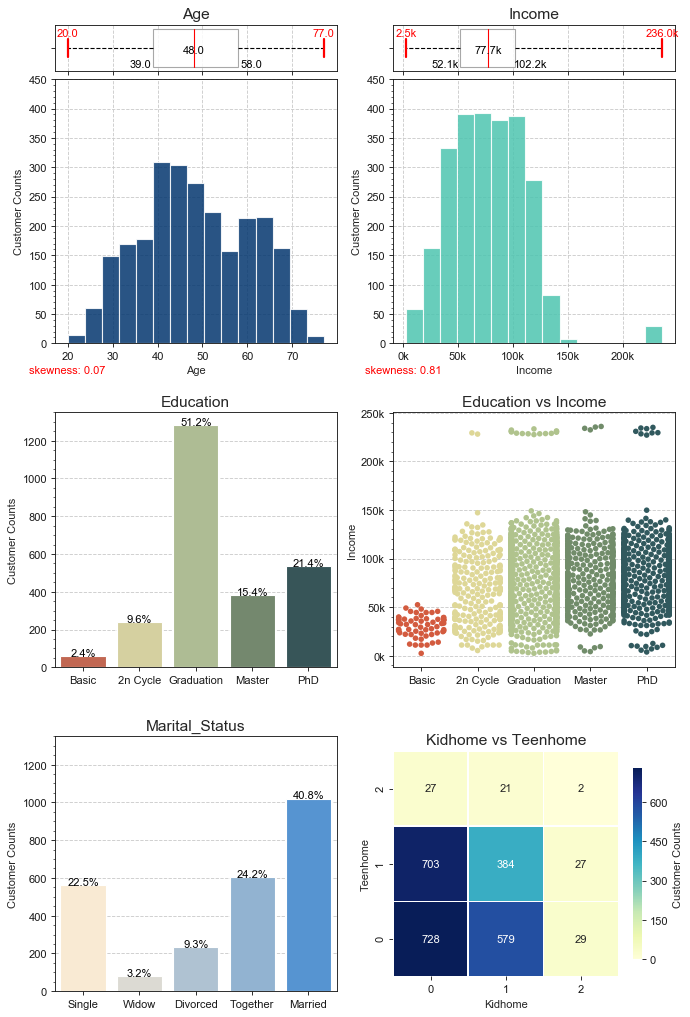

In [12]:
figDemographics_all = f_demographics_analysis(df)
plt.show(figDemographics_all)

<a class="anchor" id="demographics-ki"></a>
<b>Key Insights</b>:
   ><p> The majority of the customers have an <b>age between 38 and 58 years old</b>. </p>
   ><p>Regarding the Education level, <b>88%</b> (2200 out of 2500) of <b>customers are graduated or have a higher education level</b> (Gratuated, Master or PhD)</p>
   ><p>In general, <b>Income</b> seems to be <b>relatively normal distributed</b>. However, there is a <b>group of 29 customers whose household's income is higher than 220 k.</b></p>
   ><p>Also, regarding the <b>Marital Status</b>, the <b>majority of customers live as a couple</b> ("Together" or "Married").</p>
   ><p> The majority of Great Library's <b>customers have less than 2 teeens and 2 kids in the household</b>. </p>
</p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="others"></a>
#### 2.3.2: Others

What about their relationship with Great Library? When did it start? Which factors are associated with different levels of expenditure in books? What are the most relevant channels?

The following cells will contains several plots that might answer to these questions. In some, in order to retrieve a more general perspective, a composite variable (`MntTotal`) will be used, which translates in the total expenditure in books, independent of the type of books bought.

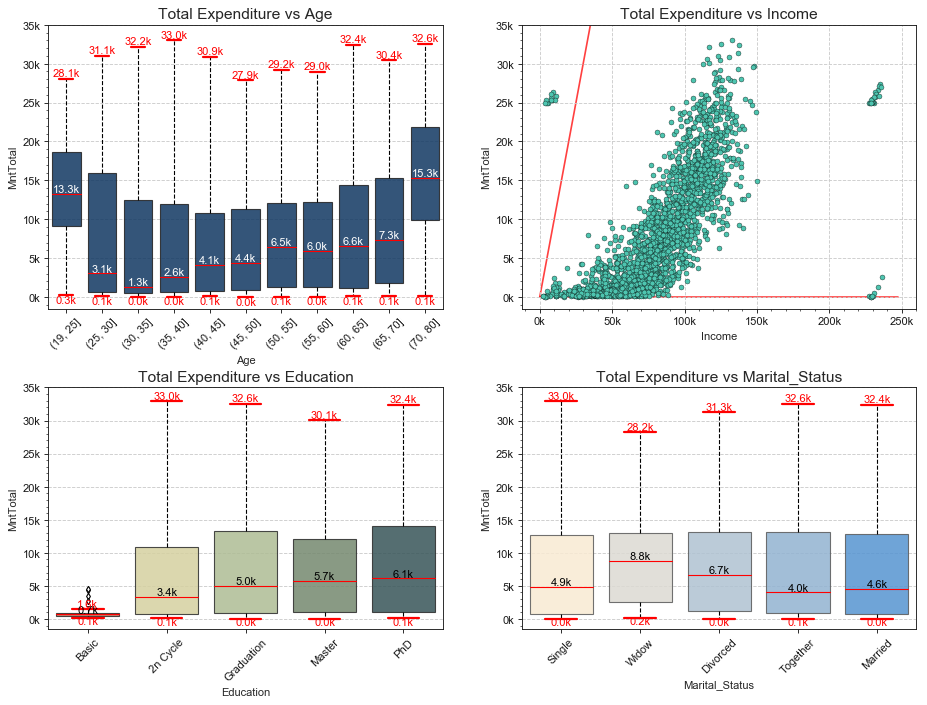

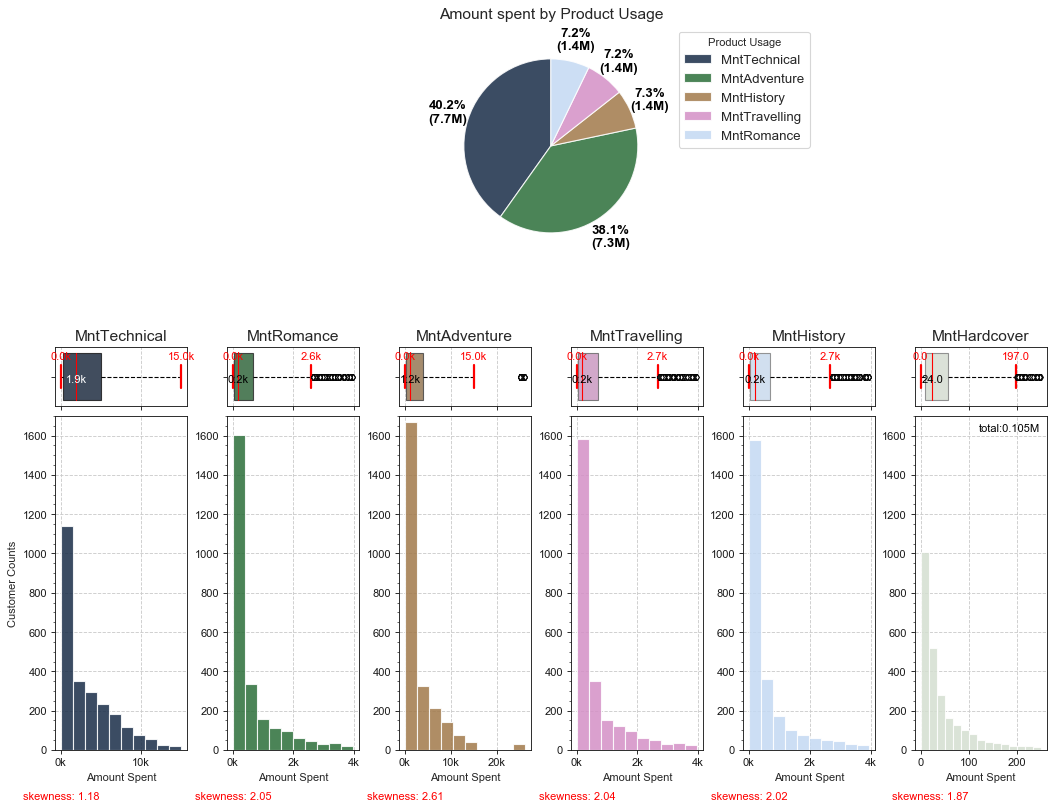

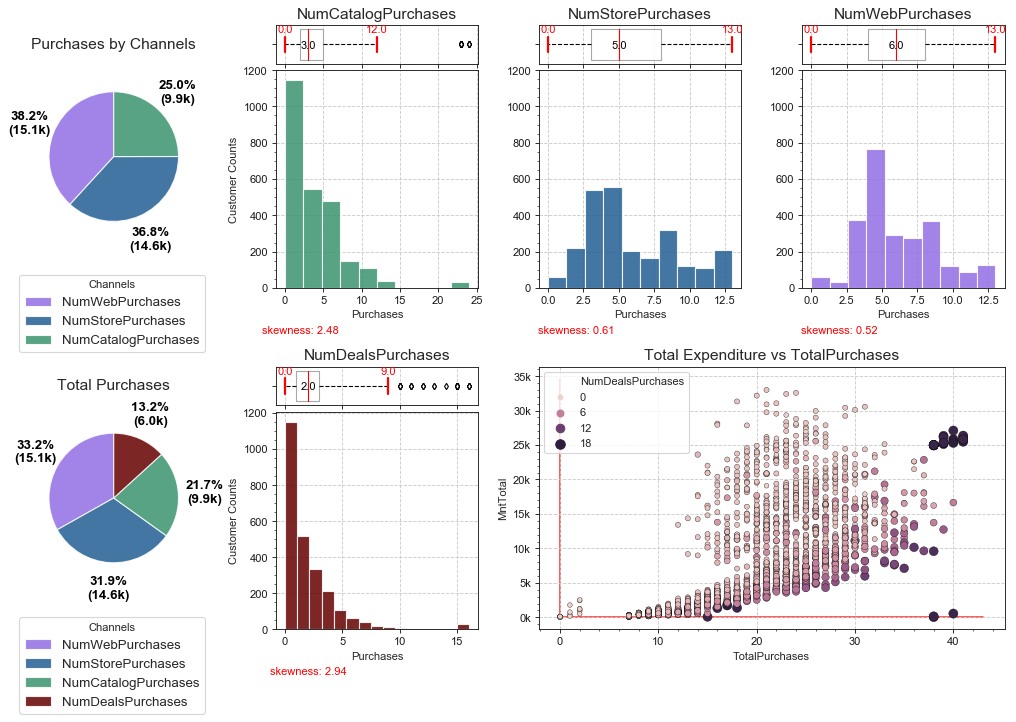

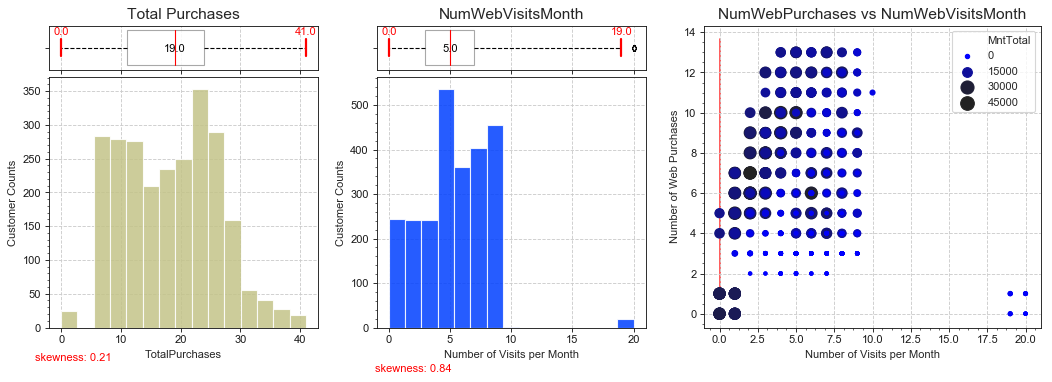

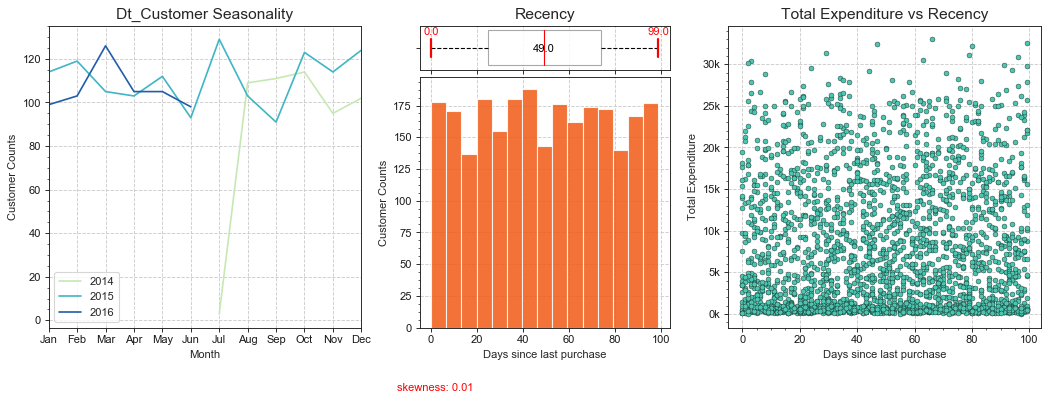

In [13]:
figMntTotalDemographics = f_exploratory_MntTotalDemographics(df)
plt.show(figMntTotalDemographics)

figProductUsage = f_exploratory_ProductUsage(df)
plt.show(figProductUsage)

figChannels = f_exploratory_Channels(df)
plt.show(figChannels)

figPurchases = f_exploratory_Purchases(df)
plt.show(figPurchases)

figRecency = f_exploratory_Recency(df)
plt.show(figRecency)

<a class="anchor" id="others-ki"></a>
<b>Key Insights</b>:
   ><p> In general, the <b>total Expenditure</b> seems to have an <b>uniform distribution</b> across the different age groups. However, the customers with the <b>highest amount spent (on average)</b> fall between the <b>70 and 80</b> years old. </p>
   ><p> There are three small groups of customers that doensn't follow the same pattern as the majority: the ones that <b>buy a lot but they almost don't have any income</b>, customers with a <b>huge income but a total amount spent near to 0</b> and, finally, customers <b>with a huge income and total amount spent</b>. </p>
   ><p> There are <b> no significant differences in books' expenditure across education levels </b>, with exception of the Basic one, since the very few customers in this condition spent way less when compared to the others. </p>
   ><p> At the same time, it is also possible to infer <b>no difference in the amount spent across the distinct marital status</b>. </p>
   ><p>In terms of value, <b> Technical </b> and <b> Adventure Books </b> are the most sold genres. </p>
   ><p>The revenue generated from the <b> hard cover books additional fee is insignificant </b> when compared to the total value from books' sales (around 105 k).</p>
   ><p> In terms of shape, the distribution of amount spent by the customers in each type is similar. Nevertheless, it seems important to highlight that the x-scales are not the same. Indeed, as mentioned before, <b> Technical and Adventure books register considerably higher sales</b>. For the latter type, however, it is possible to identify a <b>group of 32 outliers that spent more than 24.000 in Adventure books. </b> </p>
   ><p>There is no clear preferable channel as they are all relevant.</p>
   ><p>Concerning the way customers buy books, it seems <b>customers that purchase via web buys books more often than people that purchases through catalogs or in the store</b>, on average.</p>
   ><p>As mentioned before, there is a particular <b> group of 18 customers that visits the website several times and makes, at most, one purchase</b>, which are clearly outliers. Also, it's possible to highlight a <b>group of 16 customers that never visited the website and, yet, had made purchases through it</b>. </p>
   ><p><b>recency</b>, its distribution is <b>asymptotically uniform</b>. </p>
   ><p>There is <b>no observable pattern in the customers' enrolments</b> and also no seasonality. </p>
   ><p>With respect to <b>recency</b>, its distribution is <b>asymptotically uniform</b>. </p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="verify-data-quality"></a>
### 2.4: Verify the data quality

Are there any missing values on the data? And missclassifications? What about outliers?

In [14]:
# Check for duplicates in the data
np.shape(df['Custid'].unique())[0]

2500

In [15]:
# Inspect the records where Income > 200 k & Total Expenditure > 20 k
df[(df['Income'] > 200000) & (df['MntTotal'] > 20000)]

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
193   100005417        1950         PhD       Together  230997        0   
217   100005648        1968  Graduation       Together  230376        1   
350   100007046        1980  Graduation        Married  232347        0   
746   100011864        1944         PhD        Married  233759        0   
850   100013124        1965  Graduation       Together  231454        0   
885   100013520        1974  Graduation         Single  229146        1   
1299  100018329        1956      Master        Married  232541        0   
1342  100018797        1975  Graduation        Married  227659        0   
1594  100022001        1972  Graduation       Divorced  231222        0   
1730  100023717        1949         PhD          Widow  229634        1   
1828  100024995        1976  Graduation        Married  230768        0   
1858  100025424        1985    2n Cycle         Single  229419        1   
1909  100025994        1979         PhD       Divorced  235076        0   
1938  100026318        1974  Graduation        Married  228714        1   
1974  100026726        1971         PhD        Married  228450        1   
2148  100028811        1946         PhD       Together  234410        0   
2175  100029159        1973      Master       Together  234103        0   
2186  100029225        1963    2n Cycle        Married  228174        1   
2232  100029723        1971      Master        Married  235408        0   
2329  100030941        1979  Graduation        Married  228493        2   

      Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
193          1  2016-01-28       88            39           0         24933   
217          1  2016-01-04       90           132           2         24989   
350          1  2015-07-23       37           771         102         25161   
746          0  2014-08-31        3           225         214         25833   
850          1  2015-01-07       34           441          82         25437   
885          0  2015-05-27       57            28          32         24962   
1299         1  2014-10-23       21           804          80         25097   
1342         1  2015-07-29       45            11           6         24939   
1594         1  2014-10-17       29           294          72         25191   
1730         1  2014-11-19       15           502           0         24995   
1828         1  2015-05-21       99           117          42         25314   
1858         0  2015-05-25       56             7          10         24977   
1909         0  2015-10-20       96          1052         114         26021   
1938         1  2015-10-11        8            14           0         24938   
1974         0  2015-04-07       54           203          18         25043   
2148         0  2015-10-14       76           897          68         26069   
2175         1  2015-11-10       87           612          46         25092   
2186         2  2015-07-28       21             6          14         24963   
2232         0  2015-05-24       92           674         184         26034   
2329         1  2015-01-19       89            10           6         24963   

      MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
193               0           0             0                  0   
217              10           6             2                 15   
350              82          20            16                 16   
746             106         192             4                  0   
850             266         142            14                 15   
885              26          16             1                  0   
1299              0         122            12                  0   
1342              2          16             2                  0   
1594             84         120            13                 16   
1730              0           0             3                 16   
1828            170      

In [16]:
# Inspect the records where Income > 200 k & Total Expenditure < 20 k
df[(df['Income'] > 200000) & (df['MntTotal'] < 20000)]

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
195   100005423        1983  Graduation       Divorced  228939        1   
320   100006785        1953  Graduation         Single  230129        1   
374   100007376        1969         PhD       Together  227160        1   
444   100008213        1974  Graduation       Together  231033        0   
1101  100016094        1961  Graduation        Married  228491        0   
1152  100016688        1979      Master        Married  236036        0   
1471  100020483        1983  Graduation         Single  228733        2   
1512  100021050        1964  Graduation        Married  233529        0   
2226  100029675        1968         PhD        Married  229426        0   

      Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
195          0  2015-12-15       97             9           2            12   
320          1  2015-09-02       33            64           4            20   
374          0  2016-01-20       16            23           6            33   
444          1  2015-01-10       13           442           8            59   
1101         1  2014-12-20       55            29           0            14   
1152         0  2015-06-28       49           795         222          1110   
1471         0  2015-09-13       46             9          16            23   
1512         0  2015-11-17       24           382         320           374   
2226         1  2016-02-02       53            63           4            32   

      MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
195               2           2             1                  0   
320               6           4             2                  0   
374               8           4             1                  0   
444               8           0             3                  0   
1101              0           0             1                  0   
1152            332          74            10                  0   
1471             14           0             4                  0   
1512            178           0             4                  0   
2226              2           4             4                  0   

      NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
195                 0                    0                  0   
320                 0                    0                  0   
374                 0                    0                  0   
444                 1                    0                  1   
1101                0                    0                  0   
1152                1                    0                  1   
1471                0                    0                  0   
1512                0                    1                  1   
2226                0                    0                  0   

      NumWebVisitsMonth  Unnamed: 29  Unnamed: 30  Age  MntTotal   AgeBins  \
195                   1            0          NaN   36        27  (35, 40]   
320                   1            1          NaN   66        98  (65, 70]   
374                   1            0          NaN   50        74  (45, 50]   
444                   1            1          NaN   45       517  (40, 45]   
1101                  1            0          NaN   58        43  (55, 60]   
1152                  0            0          NaN   40      2533  (35, 40]   
1471                  1            0          NaN   36        62  (35, 40]   
1512                  0            0          NaN   55      1254  (50, 55]   
2226                  1            0          NaN   51       105  (50, 55]   

      TotalPurchases  
195                0  
320                0  
374                0  
444                2  
1101               0  
1152               2  
1471               0  
1512               2  
2226               0

In [17]:
# Inspect the records where NumWebVisitsMonth > 15
df[df['NumWebVisitsMonth'] > 15]

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
88    100004157        1957  Graduation        Married    5042        0   
182   100005297        1967  Graduation       Together   13174        2   
277   100006293        1951      Master       Together    9415        0   
414   100007859        1977  Graduation        Married    9038        0   
527   100009233        1979  Graduation       Together    3250        1   
805   100012491        1985  Graduation         Single    4409        1   
1031  100015314        1982         PhD        Married    9875        0   
1065  100015638        1952         PhD       Together   10443        0   
1092  100015968        1977  Graduation        Married    2515        1   
1482  100020582        1958         PhD       Together    8667        0   
1686  100023087        1960  Graduation        Married   10940        0   
1722  100023591        1971  Graduation       Together    3794        1   
1817  100024794        1964         PhD        Married    7057        1   
1971  100026663        1986    2n Cycle       Together    5361        1   
2015  100027167        1986      Master         Single    4995        1   
2061  100027698        1970      Master        Married    4273        1   
2065  100027755        1987    2n Cycle       Together    9199        1   
2178  100029189        1989         PhD        Married    9538        0   

      Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
88           1  2015-01-20       55            62           0            33   
182          1  2014-10-31       87           925         196           399   
277          1  2015-01-23       30           420          30           279   
414          1  2014-08-31       34           664          16           212   
527          0  2015-07-11       87             9           0            23   
805          0  2015-10-15       70             8           0            26   
1031         0  2014-08-22       18           714         250          1259   
1065         0  2015-07-24        1          1110          60           531   
1092         0  2016-01-29       80             9          18            17   
1482         1  2016-05-23       87           196          22           120   
1686         0  2015-09-23       38           550          80           366   
1722         0  2015-10-09        0            22           4            23   
1817         1  2016-02-25       78           112           6            51   
1971         0  2015-02-20       74            47         180           141   
2015         0  2015-08-20       80            38          12            32   
2061         0  2016-05-01        2             3           2             6   
2065         0  2014-12-21        9           304         214           363   
2178         0  2015-10-07       55           847          42           260   

      MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
88                4           2             3                  0   
182              28         196             9                 16   
277             232          76             2                  0   
414              16          16             2                  0   
527              34           6             2                  0   
805              24          56             1                  0   
1031             34         178             8                  0   
1065             60          30             2                  0   
1092             20          20             2                 15   
1482             10          10             1                  0   
1686            244         102            10                 15   
1722              4           4             0                  0   
1817              2           2             3                  0   
1971            188         206            12                  0   
2015              0          20             3                

<a class="anchor" id="dataquality-ki"></a>
<b>Key Insights</b>:


   >- <u>Missing Data</u>: No missing values were observed on the data.
   > 
   >   
   >- <u>Data Consistency</u>: Following on the anlysis from the plots above it is possible to observe:
    <p>Total Expenditure vs Income: There are records with a Total Expenditure that is greater than the Income!</p>
    <p>Total Expenditure vs TotalPurchases: There are records with a Total Expenditure > 0 but without Purchases!</p>
    <p>NumWebPurchases vs NumWebVisitsMonth: There are records with NumWebPurchases > 0 without NumWebVisitsMonth!</p>
   >   
   >      
   >- <u>Outliers</u> (considering an IQR of 3):
    <p>Most of the records with an Income over 200 k and Total Expenditure over 20 k have a number of CatalogPurchases over 20 (identified as a potential outlier), a number of Deals Purchases over 10 (identified as a potential outlier) and an amount spent on Adventure books over 20 k (identified as a potential outlier). </p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="data-preparation"></a>
# 3. Data Preparation
<a class="anchor" id="clean-the-data"></a>
### 3.1: Clean the data

<a class="anchor" id="inconsistent-records"></a>
#### 3.1.1: Drop inconsistent records

- `Total Expenditure` vs `Income`

In [18]:
df_treated = df.copy()
nrecords_original = np.shape(df_treated)[0]
df_treated = df_treated[df_treated['MntTotal'] < df_treated['Income']]

- `Total Expenditure` vs `TotalPurchases`

In [19]:
df_treated = df_treated[((df_treated['MntTotal'] > 0) & (df_treated['TotalPurchases'] > 0))]

- `NumWebPurchases` vs `NumWebVisitsMonth`

In [20]:
df_treated = df_treated[(((df_treated['NumWebPurchases'] > 0) & (df_treated['NumWebVisitsMonth'] > 0)) | \
                    ((df_treated['NumWebPurchases'] == 0) & (df_treated['NumWebVisitsMonth'] >= 0)))]

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="outliers"></a>
#### 3.1.2: Remove outliers

In [21]:
# drop records where Income > 200 k 
df_treated = df_treated[df_treated['Income'] < 200000]  
# drop records where Number of visits per month >= 15 
df_treated = df_treated[df_treated['NumWebVisitsMonth'] < 15]
# drop records where Number of Catalog Purchases >= 20 
df_treated = df_treated[df_treated['NumCatalogPurchases'] < 20]

In [22]:
dropped = nrecords_original - np.shape(df_treated)[0]
print('total dropped rows: ' + str('{:.1f}%'.format(dropped / nrecords_original * 100)))

total dropped rows: 2.8%


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="transform-the-data"></a>
### 3.2: Transform the data

<a class="anchor" id="transform-normality"></a>
#### 3.2.1: Transformations to archieve "normality"

- Product Usage (correct for the highly right skewed distributions)

In [23]:
# Use Box-Cox Transformations (the lambda coefficients were obtained by searching 
# the one that maximizes the log-likelihood function)
var_list = ['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory', 'MntHardcover']

for index, item in enumerate(var_list):
    var_aux = eval('df_treated[' + '\'' + item + '\'' + ']') + 0.1
    boxcox_out = sp.stats.boxcox(var_aux)
    lmbda = '{:.3f}'.format(boxcox_out[1])
    exec('df_treated.loc[:, ' + '\'' + item + '_z' + '\'' + '] = var_aux.map(lambda x: (x**' + lmbda +\
         ' - 1) / ' + lmbda + ')')
df_treated.head(n = 5)

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
0  100003119        1963         PhD       Divorced  102929        0   
1  100003134        1953      Master        Married  120449        0   
2  100003152        1974         PhD       Together   55318        1   
3  100003155        1974  Graduation        Married   40732        1   
4  100003158        1962  Graduation       Divorced   22048        0   

   Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
0         1  2015-07-22       10          5320        1760          2520   
1         0  2015-10-31       75          5320        2520          7350   
2         0  2014-11-24       31            90           0            90   
3         0  2016-03-16       30            50         140           210   
4         0  2016-04-16       37             0          80            75   

   MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
0           1060         880           133                  3   
1           2520        2520           126                  1   
2             60          20             5                  1   
3              0         100             7                  1   
4             80           0             4                  1   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                9                    4                 13                  5   
1                7                    6                 11                  1   
2                3                    1                  2                  9   
3                3                    1                  3                  6   
4                3                    1                  3                  3   

   Unnamed: 29  Unnamed: 30  Age  MntTotal   AgeBins  TotalPurchases  \
0            0       1934.0   56     11540  (55, 60]              29   
1            1        404.0   66     20230  (65, 70]              25   
2            0          NaN   45       260  (40, 45]               7   
3            0          NaN   45       500  (40, 45]               8   
4            0          NaN   57       235  (55, 60]               8   

   MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0       29.480992     17.368671       12.259885        15.074638   
1       29.480992     19.040225       14.881761        18.854585   
2        8.235585     -1.843253        5.781866         6.328719   
3        6.581903      8.459886        7.216321        -1.847177   
4       -1.757949      7.031864        5.489962         6.996683   

   MntHistory_z  MntHardcover_z  
0     14.643880        8.965673  
1     19.322776        8.802696  
2      4.139151        1.971364  
3      7.642684        2.468718  
4     -1.837389        1.663140

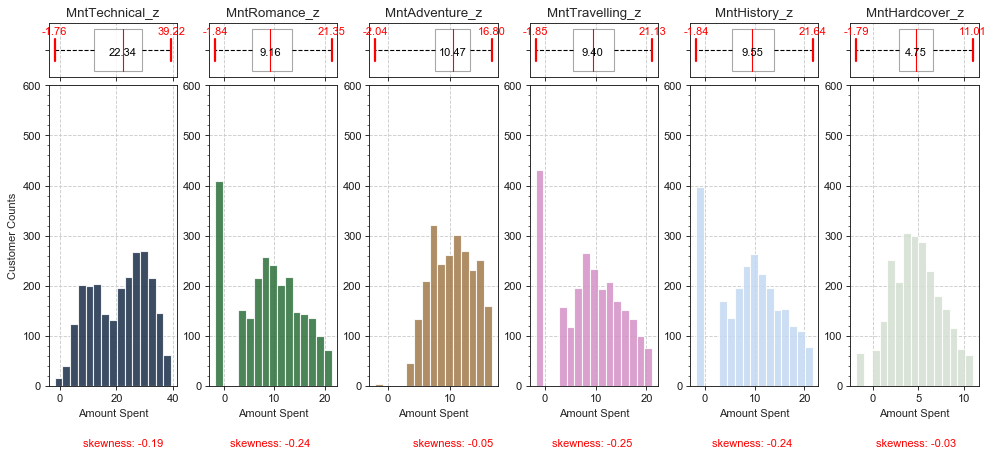

In [24]:
var_list = ['MntTechnical_z', 'MntRomance_z', 'MntAdventure_z', 'MntTravelling_z', 'MntHistory_z']
color_list = [Usages_color_dict.get(value) for value in list_Usage]
var_list.append('MntHardcover_z')
color_list.append('#d4ded0')
max_list = [600, 600, 600, 600, 600, 600]

figTransform_prodUsage = f_transformHist_analysis(df_treated, var_list , color_list, max_list)
plt.show(figTransform_prodUsage)

In [25]:
# inspect the records where it was oberved a spike on the most left side
test = df_treated[df_treated['MntRomance_z'] < 0]
print(test['MntRomance'].describe())
print(test[test['MntRomance'] == 0]['MntRomance'].count())

count    410.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: MntRomance, dtype: float64
410


This spike corresponds to the records with zero amount spent on `MntRomance` which is statistically significant and, therefore, a flag variable will be signal to cover those records.

In [26]:
# inspect the records where it was oberved a spike on the most left side
test = df_treated[df_treated['MntTravelling_z'] < 0]
print(test['MntTravelling'].describe())
print(test[test['MntTravelling'] == 0]['MntTravelling'].count())

count    432.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: MntTravelling, dtype: float64
432


This spike corresponds to the records with zero amount spent on `MntTravelling` which is statistically significant and, therefore, a flag variable will be signal to cover those records.

In [27]:
# inspect the records where it was oberved a spike on the most left side
test = df_treated[df_treated['MntHistory_z'] < 0]
print(test['MntHistory'].describe())
print(test[test['MntHistory'] == 0]['MntHistory'].count())

count    397.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: MntHistory, dtype: float64
397


This spike corresponds to the records with zero amount spent on `MntHistory` which is statistically significant and, therefore, a flag variable will be signal to cover those records.

In [28]:
# inspect the records where it was oberved a spike on the most left side
test = df_treated[df_treated['MntAdventure_z'] < 0]
print(test['MntAdventure'].describe())
print(test[test['MntAdventure'] == 0]['MntAdventure'].count())

count    3.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: MntAdventure, dtype: float64
3


This spike corresponds to the records with zero amount spent on `MntAdventure` which is not statistically significant.

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="flag-variables"></a>
#### 3.2.2: Create flag variables

- Nominal Variables

In [29]:
# Education
list_bin = [1 if value == 'Basic' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_Basic_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == '2n Cycle' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_2nCycle_flag' + '\'' + '] = list_bin')  

list_bin = [1 if value == 'Graduation' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_Graduation_flag' + '\'' + '] = list_bin')  

list_bin = [1 if value == 'Master' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_Master_flag' + '\'' + '] = list_bin')  


# Marital_Status
list_bin = [1 if value == 'Single' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Single_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 'Widow' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Widow_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 'Divorced' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Divorced_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 'Together' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Together_flag' + '\'' + '] = list_bin')


# Kidhome
list_bin = [1 if value == 0 else 0 for value in eval('df_treated[' + '\'' + 'Kidhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Kidhome_0_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 1 else 0 for value in eval('df_treated[' + '\'' + 'Kidhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Kidhome_1_flag' + '\'' + '] = list_bin')


# Teenhome
list_bin = [1 if value == 0 else 0 for value in eval('df_treated[' + '\'' + 'Teenhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Teenhome_0_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 1 else 0 for value in eval('df_treated[' + '\'' + 'Teenhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Teenhome_1_flag' + '\'' + '] = list_bin')

In [30]:
df_treated.head(n = 5)

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
0  100003119        1963         PhD       Divorced  102929        0   
1  100003134        1953      Master        Married  120449        0   
2  100003152        1974         PhD       Together   55318        1   
3  100003155        1974  Graduation        Married   40732        1   
4  100003158        1962  Graduation       Divorced   22048        0   

   Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
0         1  2015-07-22       10          5320        1760          2520   
1         0  2015-10-31       75          5320        2520          7350   
2         0  2014-11-24       31            90           0            90   
3         0  2016-03-16       30            50         140           210   
4         0  2016-04-16       37             0          80            75   

   MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
0           1060         880           133                  3   
1           2520        2520           126                  1   
2             60          20             5                  1   
3              0         100             7                  1   
4             80           0             4                  1   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                9                    4                 13                  5   
1                7                    6                 11                  1   
2                3                    1                  2                  9   
3                3                    1                  3                  6   
4                3                    1                  3                  3   

   Unnamed: 29  Unnamed: 30  Age  MntTotal   AgeBins  TotalPurchases  \
0            0       1934.0   56     11540  (55, 60]              29   
1            1        404.0   66     20230  (65, 70]              25   
2            0          NaN   45       260  (40, 45]               7   
3            0          NaN   45       500  (40, 45]               8   
4            0          NaN   57       235  (55, 60]               8   

   MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0       29.480992     17.368671       12.259885        15.074638   
1       29.480992     19.040225       14.881761        18.854585   
2        8.235585     -1.843253        5.781866         6.328719   
3        6.581903      8.459886        7.216321        -1.847177   
4       -1.757949      7.031864        5.489962         6.996683   

   MntHistory_z  MntHardcover_z  Education_Basic_flag  Education_2nCycle_flag  \
0     14.643880        8.965673                     0                       0   
1     19.322776        8.802696                     0                       0   
2      4.139151        1.971364                     0                       0   
3      7.642684        2.468718                     0                       0   
4     -1.837389        1.663140                     0                       0   

   Education_Graduation_flag  Education_Master_flag  MStatus_Single_flag  \
0                          0                      0                    0   
1                          0                      1                    0   
2                          0                      0                    0   
3                          1                      0                    0   
4                          1                      0                    0   

   MStatus_Widow_flag  MStatus_Divorced_flag  MStatus_Together_flag  \
0                   0                      1                      0   
1                   0                      0                      0   
2                   0                      0                      1   
3                   0                      0                      0   
4                   0                      1                      0   

   Kidhome_0_flag  Kidhom

- Transformed Variables

In [31]:
# Create flag variables for the Transformed Variables (whenever required based on the previous analysis)
var_list = ['MntRomance_z', 'MntTravelling_z', 'MntHistory_z']
for index, item in enumerate(var_list):
    list_bin = []
    list_bin = [0 if value < 0 else 1 for value in eval('df_treated[' + '\'' + item + '\'' + ']')]
    exec('df_treated.loc[:, ' + '\'' + item.split('_')[0] + '_flag' + '\'' + '] = list_bin')

#df_treated.loc[:, 'Income_flag'] = [1 if value > 200000 else 0 for value in df_treated['Income']]

In [32]:
df_treated.head(n = 5)

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
0  100003119        1963         PhD       Divorced  102929        0   
1  100003134        1953      Master        Married  120449        0   
2  100003152        1974         PhD       Together   55318        1   
3  100003155        1974  Graduation        Married   40732        1   
4  100003158        1962  Graduation       Divorced   22048        0   

   Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
0         1  2015-07-22       10          5320        1760          2520   
1         0  2015-10-31       75          5320        2520          7350   
2         0  2014-11-24       31            90           0            90   
3         0  2016-03-16       30            50         140           210   
4         0  2016-04-16       37             0          80            75   

   MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
0           1060         880           133                  3   
1           2520        2520           126                  1   
2             60          20             5                  1   
3              0         100             7                  1   
4             80           0             4                  1   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                9                    4                 13                  5   
1                7                    6                 11                  1   
2                3                    1                  2                  9   
3                3                    1                  3                  6   
4                3                    1                  3                  3   

   Unnamed: 29  Unnamed: 30  Age  MntTotal   AgeBins  TotalPurchases  \
0            0       1934.0   56     11540  (55, 60]              29   
1            1        404.0   66     20230  (65, 70]              25   
2            0          NaN   45       260  (40, 45]               7   
3            0          NaN   45       500  (40, 45]               8   
4            0          NaN   57       235  (55, 60]               8   

   MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0       29.480992     17.368671       12.259885        15.074638   
1       29.480992     19.040225       14.881761        18.854585   
2        8.235585     -1.843253        5.781866         6.328719   
3        6.581903      8.459886        7.216321        -1.847177   
4       -1.757949      7.031864        5.489962         6.996683   

   MntHistory_z  MntHardcover_z  Education_Basic_flag  Education_2nCycle_flag  \
0     14.643880        8.965673                     0                       0   
1     19.322776        8.802696                     0                       0   
2      4.139151        1.971364                     0                       0   
3      7.642684        2.468718                     0                       0   
4     -1.837389        1.663140                     0                       0   

   Education_Graduation_flag  Education_Master_flag  MStatus_Single_flag  \
0                          0                      0                    0   
1                          0                      1                    0   
2                          0                      0                    0   
3                          1                      0                    0   
4                          1                      0                    0   

   MStatus_Widow_flag  MStatus_Divorced_flag  MStatus_Together_flag  \
0                   0                      1                      0   
1                   0                      0                      0   
2                   0                      0                      1   
3                   0                      0                      0   
4                   0                      1                      0   

   Kidhome_0_flag  Kidhom

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="normalize-the-data"></a>
#### 3.2.3: Normalize the data

In [33]:
# Filter out the columns to apply the normalization
df_treated = df_treated.assign(Age_z = df_treated['Age'].values)
df_treated = df_treated.assign(Income_z = df_treated['Income'].values)
df_treated = df_treated.assign(MntTotal_z = df_treated['MntTotal'].values)
df_treated = df_treated.assign(NumCatalogPurchases_z = df_treated['NumCatalogPurchases'].values)
df_treated = df_treated.assign(NumStorePurchases_z = df_treated['NumStorePurchases'].values)
df_treated = df_treated.assign(NumWebPurchases_z = df_treated['NumWebPurchases'].values)
df_treated = df_treated.assign(NumDealsPurchases_z = df_treated['NumDealsPurchases'].values)
df_treated = df_treated.assign(TotalPurchases_z = df_treated['TotalPurchases'].values)
df_treated = df_treated.assign(NumWebVisitsMonth_z = df_treated['NumWebVisitsMonth'].values)
df_treated = df_treated.assign(Recency_z = df_treated['Recency'].values)

df_treated_z = df_treated[df_treated.columns[pd.Series(df_treated.columns).str.contains('_z')]]

In [34]:
df_treated_z.head(n = 5)

MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0       29.480992     17.368671       12.259885        15.074638   
1       29.480992     19.040225       14.881761        18.854585   
2        8.235585     -1.843253        5.781866         6.328719   
3        6.581903      8.459886        7.216321        -1.847177   
4       -1.757949      7.031864        5.489962         6.996683   

   MntHistory_z  MntHardcover_z  Age_z  Income_z  MntTotal_z  \
0     14.643880        8.965673     56    102929       11540   
1     19.322776        8.802696     66    120449       20230   
2      4.139151        1.971364     45     55318         260   
3      7.642684        2.468718     45     40732         500   
4     -1.837389        1.663140     57     22048         235   

   NumCatalogPurchases_z  NumStorePurchases_z  NumWebPurchases_z  \
0                      4                   13                  9   
1                      6                   11                  7   
2                      1                    2                  3   
3                      1                    3                  3   
4                      1                    3                  3   

   NumDealsPurchases_z  TotalPurchases_z  NumWebVisitsMonth_z  Recency_z  
0                    3                29                    5         10  
1                    1                25                    1         75  
2                    1                 7                    9         31  
3                    1                 8                    6         30  
4                    1                 8                    3         37

In [35]:
# Apply the Min-Max Normalization
df_treated_z = df_treated_z.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
df_treated_z.describe().T

count      mean       std  min       25%       50%  \
MntTechnical_z         2431.0  0.554518  0.238105  0.0  0.342223  0.588062   
MntRomance_z           2431.0  0.465019  0.276429  0.0  0.315435  0.474208   
MntAdventure_z         2431.0  0.662335  0.180196  0.0  0.509764  0.664206   
MntTravelling_z        2431.0  0.465234  0.280904  0.0  0.317624  0.489498   
MntHistory_z           2431.0  0.468447  0.276398  0.0  0.312897  0.484992   
MntHardcover_z         2431.0  0.511188  0.213923  0.0  0.363999  0.511110   
Age_z                  2431.0  0.497160  0.211535  0.0  0.333333  0.491228   
Income_z               2431.0  0.475794  0.216587  0.0  0.299316  0.479216   
MntTotal_z             2431.0  0.225963  0.228493  0.0  0.023303  0.142554   
NumCatalogPurchases_z  2431.0  0.247859  0.255598  0.0  0.090909  0.181818   
NumStorePurchases_z    2431.0  0.359672  0.293448  0.0  0.090909  0.272727   
NumWebPurchases_z      2431.0  0.381661  0.244370  0.0  0.181818  0.363636   
NumDealsPurchases_z    2431.0  0.163777  0.127639  0.0  0.071429  0.142857   
TotalPurchases_z       2431.0  0.338606  0.228104  0.0  0.121212  0.363636   
NumWebVisitsMonth_z    2431.0  0.464281  0.260886  0.0  0.222222  0.555556   
Recency_z              2431.0  0.497738  0.289860  0.0  0.252525  0.494949   

                            75%  max  
MntTechnical_z         0.753138  1.0  
MntRomance_z           0.665368  1.0  
MntAdventure_z         0.809847  1.0  
MntTravelling_z        0.671720  1.0  
MntHistory_z           0.668756  1.0  
MntHardcover_z         0.657796  1.0  
Age_z                  0.666667  1.0  
Income_z               0.650920  1.0  
MntTotal_z             0.383407  1.0  
NumCatalogPurchases_z  0.363636  1.0  
NumStorePurchases_z    0.545455  1.0  
NumWebPurchases_z      0.545455  1.0  
NumDealsPurchases_z    0.214286  1.0  
TotalPurchases_z       0.515152  1.0  
NumWebVisitsMonth_z    0.666667  1.0  
Recency_z              0.737374  1.0

In [36]:
df_treated[df_treated.columns[pd.Series(df_treated.columns).str.contains('_z')]] = df_treated_z
df_treated.head(n = 5)

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
0  100003119        1963         PhD       Divorced  102929        0   
1  100003134        1953      Master        Married  120449        0   
2  100003152        1974         PhD       Together   55318        1   
3  100003155        1974  Graduation        Married   40732        1   
4  100003158        1962  Graduation       Divorced   22048        0   

   Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
0         1  2015-07-22       10          5320        1760          2520   
1         0  2015-10-31       75          5320        2520          7350   
2         0  2014-11-24       31            90           0            90   
3         0  2016-03-16       30            50         140           210   
4         0  2016-04-16       37             0          80            75   

   MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
0           1060         880           133                  3   
1           2520        2520           126                  1   
2             60          20             5                  1   
3              0         100             7                  1   
4             80           0             4                  1   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                9                    4                 13                  5   
1                7                    6                 11                  1   
2                3                    1                  2                  9   
3                3                    1                  3                  6   
4                3                    1                  3                  3   

   Unnamed: 29  Unnamed: 30  Age  MntTotal   AgeBins  TotalPurchases  \
0            0       1934.0   56     11540  (55, 60]              29   
1            1        404.0   66     20230  (65, 70]              25   
2            0          NaN   45       260  (40, 45]               7   
3            0          NaN   45       500  (40, 45]               8   
4            0          NaN   57       235  (55, 60]               8   

   MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0        0.762382      0.828315        0.759004         0.736522   
1        0.762382      0.900383        0.898159         0.901044   
2        0.243891      0.000000        0.415187         0.355856   
3        0.203533      0.444216        0.491320         0.000000   
4        0.000000      0.382647        0.399694         0.384929   

   MntHistory_z  MntHardcover_z  Education_Basic_flag  Education_2nCycle_flag  \
0      0.702152        0.840329                     0                       0   
1      0.901487        0.827600                     0                       0   
2      0.254619        0.294038                     0                       0   
3      0.403880        0.332884                     0                       0   
4      0.000000        0.269964                     0                       0   

   Education_Graduation_flag  Education_Master_flag  MStatus_Single_flag  \
0                          0                      0                    0   
1                          0                      1                    0   
2                          0                      0                    0   
3                          1                      0                    0   
4                          1                      0                    0   

   MStatus_Widow_flag  MStatus_Divorced_flag  MStatus_Together_flag  \
0                   0                      1                      0   
1                   0                      0                      0   
2                   0                      0                      1   
3                   0                      0                      0   
4                   0                      1                      0   

   Kidhome_0_flag  Kidhom

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="modelling"></a>
# 4. Modelling

<a class="anchor" id="k_means"></a>
### 4.1: Clustering by k-means

<a class="anchor" id="k_means_productusage"></a>
#### 4.1.1: Product Usage segmentation

In [37]:
df_productUsage = df_treated.copy()

Variable selection (<u>We have considered the hardcover as a book feature and not a product usage</u>):
<br>
<br>
`MntTechnical_z`, `MntRomance_z`, `MntAdventure_z`, `MntTravelling_z`, `MntHistory_z`
<br>
`MntRomance_flag`, `MntTravelling_flag`, `MntHistory_flag`

In [38]:
# Create the dataframe for modelling
vars_clustering = ['MntTechnical_z', 'MntRomance_z', 'MntAdventure_z', 'MntTravelling_z', 'MntHistory_z',\
                             'MntRomance_flag', 'MntTravelling_flag', 'MntHistory_flag']

df_productUsage_KMeans = df_treated[vars_clustering].copy()
df_productUsage_KMeans.head(n = 5)

MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0        0.762382      0.828315        0.759004         0.736522   
1        0.762382      0.900383        0.898159         0.901044   
2        0.243891      0.000000        0.415187         0.355856   
3        0.203533      0.444216        0.491320         0.000000   
4        0.000000      0.382647        0.399694         0.384929   

   MntHistory_z  MntRomance_flag  MntTravelling_flag  MntHistory_flag  
0      0.702152                1                   1                1  
1      0.901487                1                   1                1  
2      0.254619                0                   1                1  
3      0.403880                1                   0                1  
4      0.000000                1                   1                0

In [39]:
# Import the required libraries
from sklearn.cluster import KMeans

In [40]:
ks = range(1, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k, n_init = 50, precompute_distances = True, max_iter = 500)

    # Fit model to samples
    model.fit(df_productUsage_KMeans)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

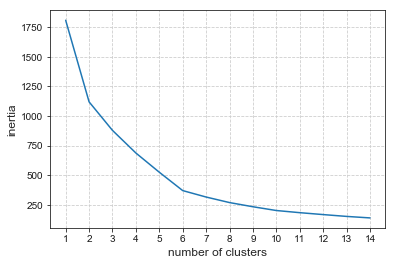

In [41]:
# Plot ks (x-axis) vs inertias (y-axis)
plt.plot(ks, inertias)
plt.xlabel('number of clusters', fontsize = 12)
plt.ylabel('inertia', fontsize = 12)
plt.xticks(np.arange(min(ks), max(ks) + 1, 1))
plt.show()

Looking at this plot `6` seems to be a good number of clusters as from this point onwards the inertia begin to decrease more slowly. So, let's try it.

In [42]:
n_clusters = 6

cluster_color_palette = sns.color_palette('Accent', n_clusters)
model_KMeans_productUsage = KMeans(n_clusters = n_clusters, n_init = 50, max_iter = 1000)
model_KMeans_productUsage.fit(df_productUsage_KMeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=6, n_init=50, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
# assign the cluster labels to the dataframe
df_productUsage['cluster'] = model_KMeans_productUsage.labels_
df_productUsage_KMeans['cluster'] = model_KMeans_productUsage.labels_

C:\Users\Administrator.W1000590\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Administrator.W1000590\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Administrator.W1000590\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Administrator.W1000590\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

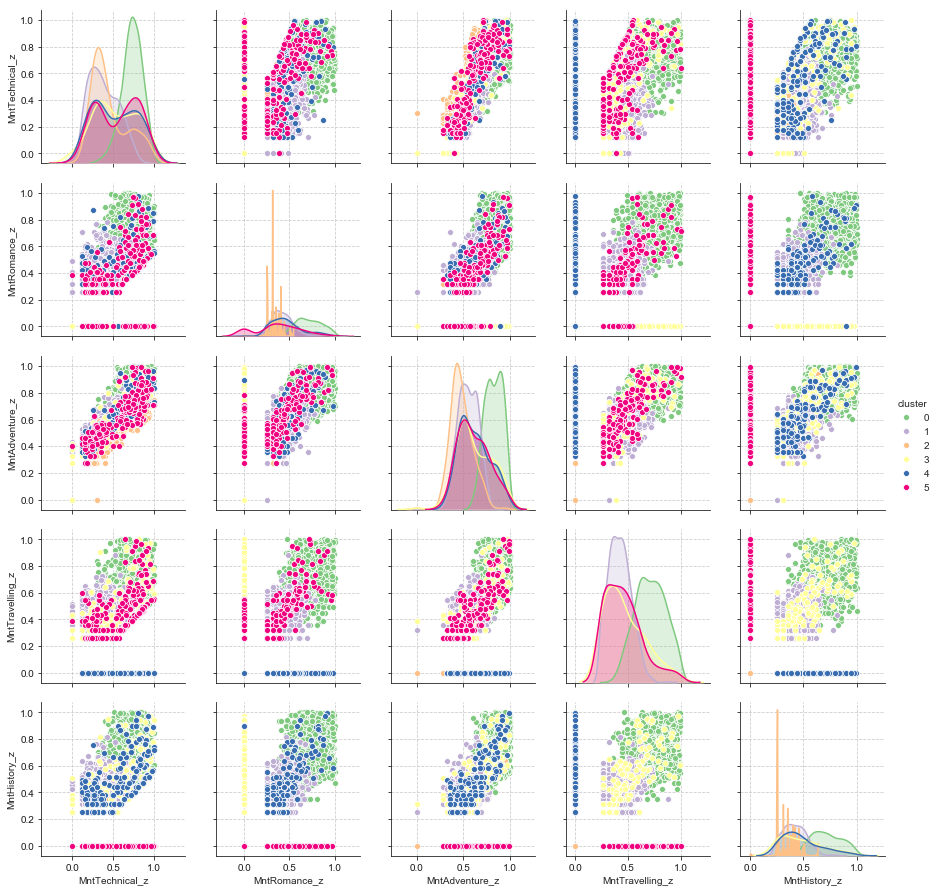

In [44]:
vars_clustering_plot = ['MntTechnical_z', 'MntRomance_z', 'MntAdventure_z', 'MntTravelling_z', 'MntHistory_z']

fig_cluster_prodUsage = f_cluster_analysis(vars_clustering_plot, df_productUsage, cluster_color_palette)
plt.show(fig_cluster_prodUsage)

In [45]:
centroids = pd.DataFrame(model_KMeans_productUsage.cluster_centers_, columns = vars_clustering)
centroids

MntTechnical_z  MntRomance_z  MntAdventure_z  MntTravelling_z  \
0        0.730313  7.160945e-01        0.826477     7.160231e-01   
1        0.381368  4.146892e-01        0.549306     4.215565e-01   
2        0.452976  6.675577e-02        0.480816    -2.498002e-15   
3        0.526940 -6.661338e-16        0.621607     4.743714e-01   
4        0.521986  4.675396e-01        0.621699    -2.053913e-15   
5        0.548022  3.754637e-01        0.613855     4.612523e-01   

   MntHistory_z  MntRomance_flag  MntTravelling_flag  MntHistory_flag  
0  7.157345e-01     1.000000e+00        1.000000e+00     1.000000e+00  
1  4.157670e-01     1.000000e+00        1.000000e+00     1.000000e+00  
2  7.347874e-02     1.992337e-01        2.775558e-15     2.222222e-01  
3  4.781246e-01    -1.887379e-15        1.000000e+00     1.000000e+00  
4  4.792194e-01     9.941520e-01        1.887379e-15     1.000000e+00  
5  9.992007e-16     7.989691e-01        1.000000e+00     1.776357e-15

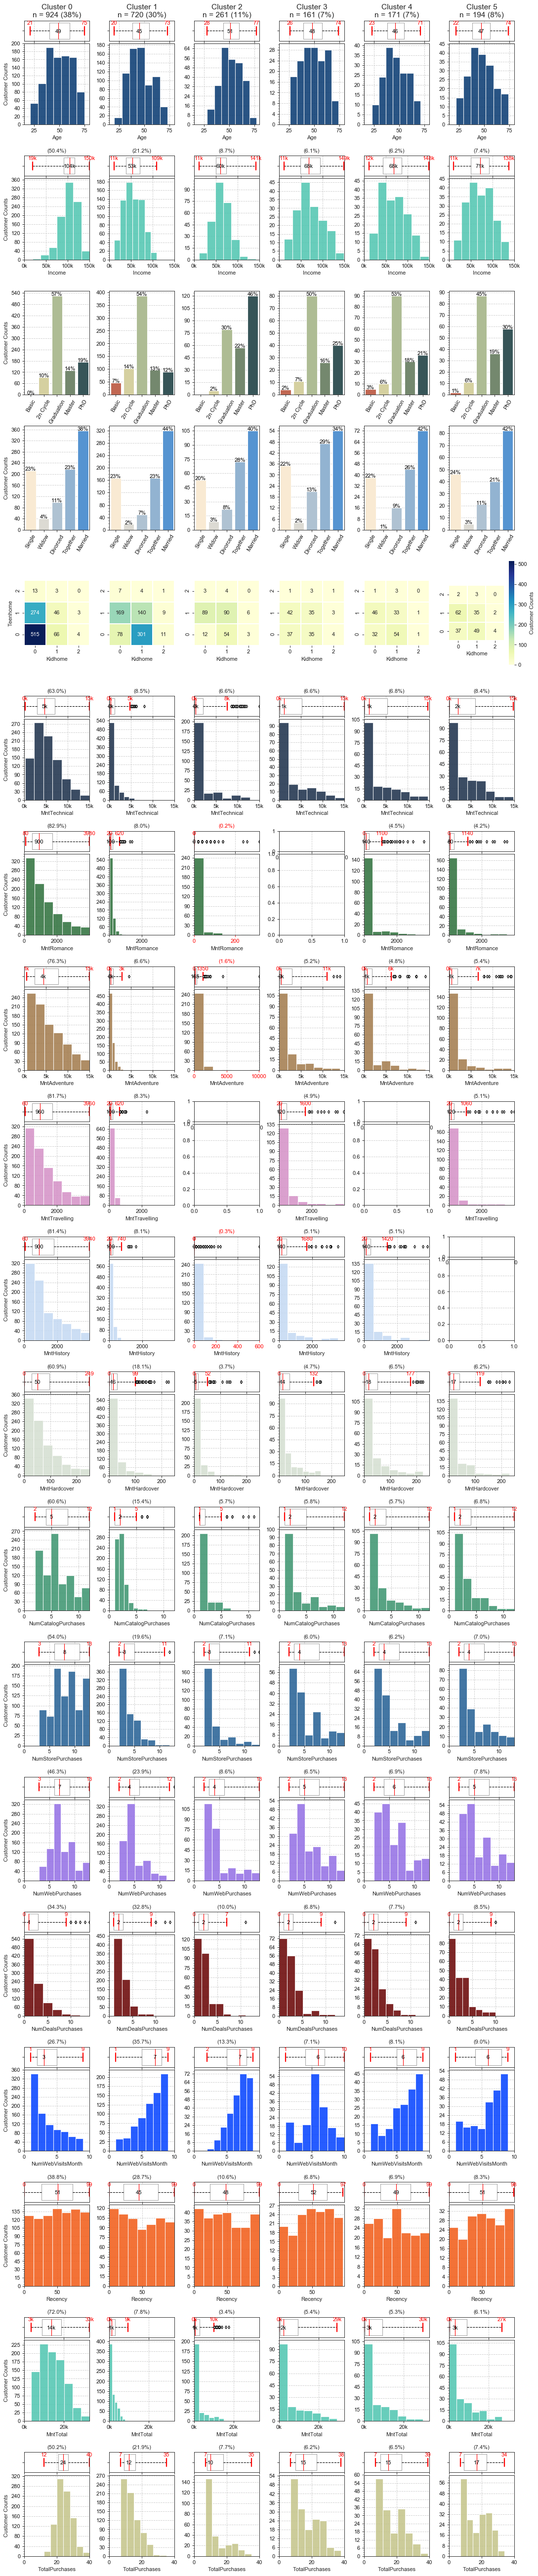

In [46]:
figClusterInt_prodUsage = f_cluster_interpretation(n_clusters, df_productUsage)
plt.show(figClusterInt_prodUsage)

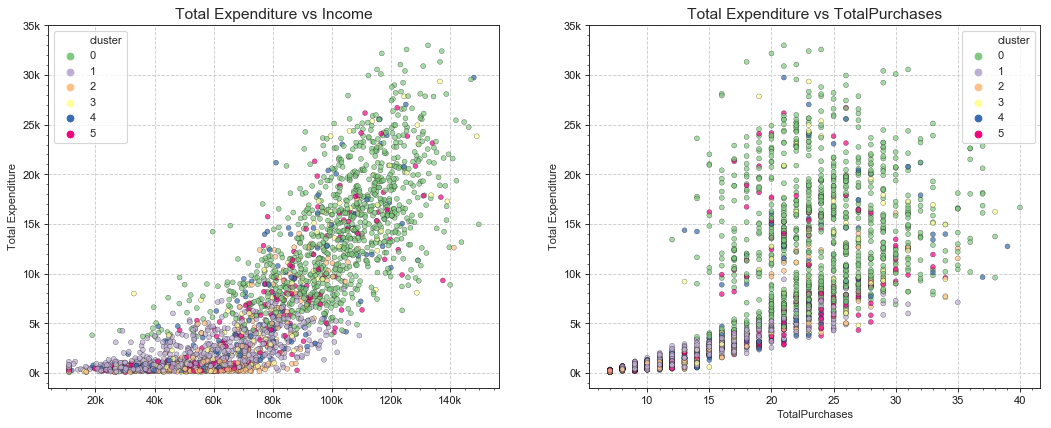

In [47]:
figClusterInt_xy_prodUsage = f_cluster_interpretation_xy(n_clusters, df_productUsage, cluster_color_palette)
plt.show(figClusterInt_xy_prodUsage)

<a class="anchor" id="k_means_productusage-ki1"></a>
<b>Key Insights 1</b>:
   ><p>The clusters are unbalanced in terms of customers. We have two clusters that stand out with higher than 30% of the total number of customers while the others have less than 15% (however none of them have less than 150 customers). </p>
   ><p> From this clustering analysis we can conclude that we have some variables that do not help much in explaining the variance in between clusters such as: `Marital Status`, `Recency` and `Age`. </p>
    ><p> <b>Highly Educated</b> (Cluster 11% n=261): In this cluster most of the customers have a higher education level (PhD, Master and Graduation). They mainly just buy Technical books and they don't buy Travelling. They do more purchases by the web and they are among the customers that visit the site more frequently. However, the total amount of purchases is comparatively lower (approx. 3%) considering that the cluster represents 11% of the customers. </p>
    ><p> <b>Non-Travelling</b> (Cluster 7% n=171): In this cluster customers don't buy Travelling books, but they buy the other books in a distinctive manner. </p>
    ><p> <b>Non-History</b> (Cluster 8% n=194): In this cluster customers don't buy History books and the top book type that they buy is Technical.</p>
    ><p> <b>Non-Romance</b> (Cluster 7% n=161): In this cluster customers don't buy Romance books and the top book type that they buy is Technical. </p>
    ><p> <b>Penny Pinchers</b> (Cluster 30% n=720): They clearly stand out as the customers that comparatively have a lower education level (Basic and 2nd Cycle with higher proportions) and a lower income (median of 53k). They represent the cluster with more kids at home and  with a relevant count of 1 teen at home. The proportion of Deals purchases is very strong (approx. 33%) but with a lower total expenditure (approx. 8%), considering that the cluster represents 30% of the customers. At the same time they represent 22% of total purchases which is highly inflated for this cluster size. They are also the customers that visit the site more often, so it seems that these customers take a lot of time to decide to buy the books, looking for deals, making a lot of purchases but with a low impact in the total expenditure.</p>
    ><p> (Cluster 38% n=924): This is the cluster with more customers and the highest income. It is not possible to identify any pattern in the books purchases since they buy a lot of all of them. Since this is a relevant cluster representing a huge chunk of the total expenditure (approx.72%), we decided to perform a cluster analysis on this specific cluster.</p>

In [48]:
# assign the labels to each cluster
dict_prodUsage_clusterLabel = {}
for idx, row in centroids.iterrows():
    if((row['MntTechnical_z'] > .7) & (row['MntAdventure_z'] > .7)):
        dict_prodUsage_clusterLabel[idx] = 'Other'
    elif(row['MntHistory_z'] < 1e-4):
        dict_prodUsage_clusterLabel[idx] = 'Non-History'
    elif(row['MntRomance_z'] < 1e-4):
        dict_prodUsage_clusterLabel[idx] = 'Non-Romance'        
    elif((row['MntTravelling_z'] < 1e-4) & (row['MntAdventure_z'] < 0.5)):
        dict_prodUsage_clusterLabel[idx] = 'Highly Educated'
    elif(row['MntTravelling_z'] < 1e-4):
        dict_prodUsage_clusterLabel[idx] = 'Non-Travelling'        
    else:
        dict_prodUsage_clusterLabel[idx] = 'Penny Pinchers'

df_productUsage.loc[:,'clusterStr'] = df_productUsage['cluster'].\
map(lambda x: dict_prodUsage_clusterLabel.get(x))
df_treated.loc[:,'clusterProdUsage'] = df_productUsage['clusterStr']
dict_prodUsage_clusterLabel

{0: 'Other',
 1: 'Penny Pinchers',
 2: 'Highly Educated',
 3: 'Non-Romance',
 4: 'Non-Travelling',
 5: 'Non-History'}

[Return to Table of Contents](#Table_Contents)

In [49]:
df_productUsage_KMeans_clusters = df_productUsage_KMeans.loc[:, 'cluster']
productUsage_KMeans_clusters = df_productUsage_KMeans_clusters.groupby(df_productUsage_KMeans_clusters).size()
cluster_id = productUsage_KMeans_clusters.idxmax()

df_cluster = df_productUsage.copy()
df_cluster = df_cluster[df_cluster['cluster'] == cluster_id]
df_cluster.head()

Custid  Year_Birth   Education Marital_Status  Income  Kidhome  \
0   100003119        1963         PhD       Divorced  102929        0   
1   100003134        1953      Master        Married  120449        0   
5   100003161        1975  Graduation         Single  124042        0   
7   100003170        1989    2n Cycle       Together   98731        0   
11  100003227        1960    2n Cycle       Together  120744        0   

    Teenhome Dt_Customer  Recency  MntTechnical  MntRomance  MntAdventure  \
0          1  2015-07-22       10          5320        1760          2520   
1          0  2015-10-31       75          5320        2520          7350   
5          0  2015-06-05       72          3870         400         10695   
7          0  2015-11-14       44           470         300           825   
11         0  2016-03-10       30          9380        2840         11310   

    MntTravelling  MntHistory  MntHardcover  NumDealsPurchases  \
0            1060         880           133                  3   
1            2520        2520           126                  1   
5             570        1064           163                  1   
7            2660        2820             7                  1   
11           2440        1620           183                  1   

    NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0                 9                    4                 13   
1                 7                    6                 11   
5                11                   12                 11   
7                 4                    3                 10   
11                7                   11                  6   

    NumWebVisitsMonth  Unnamed: 29  Unnamed: 30  Age  MntTotal   AgeBins  \
0                   5            0       1934.0   56     11540  (55, 60]   
1                   1            1        404.0   66     20230  (65, 70]   
5                   5            0          NaN   44     16599  (40, 45]   
7                   1            0          NaN   30      7075  (25, 30]   
11                  2            3          NaN   59     27590  (55, 60]   

    TotalPurchases  MntTechnical_z  MntRomance_z  MntAdventure_z  \
0               29        0.762382      0.828315        0.759004   
1               25        0.762382      0.900383        0.898159   
5               35        0.700739      0.580231        0.950813   
7               18        0.394409      0.540056        0.629873   
11              25        0.884944      0.925563        0.958845   

    MntTravelling_z  MntHistory_z  MntHardcover_z  Education_Basic_flag  \
0          0.736522      0.702152        0.840329                     0   
1          0.901044      0.901487        0.827600                     0   
5          0.634930      0.735035        0.889645                     0   
7          0.912287      0.925440        0.332884                     0   
11         0.894393      0.812538        0.918741                     0   

    Education_2nCycle_flag  Education_Graduation_flag  Education_Master_flag  \
0                        0                          0                      0   
1                        0                          0                      1   
5                        0                          1                      0   
7                        1                          0                      0   
11                       1                          0                      0   

    MStatus_Single_flag  MStatus_Widow_flag  MStatus_Divorced_flag  \
0                     0                   0                      1   
1                     0                   0                      0   
5                     1                   0                      0   
7                     0                   0                      0   
11                    0                   0                      0   

    MStatus_Together_flag  Kidhome_0_flag  Kidhome_1_flag  Teenhome_0_flag  \
0                       0       

In [50]:
# Create the dataframe for modelling
vars_clustering2 = ['MntAdventure_z', 'NumDealsPurchases_z', 'NumWebVisitsMonth']

df_cluster_KMeans = df_cluster[vars_clustering2].copy()
df_cluster_KMeans.head(n = 5)

MntAdventure_z  NumDealsPurchases_z  NumWebVisitsMonth
0         0.759004             0.214286                  5
1         0.898159             0.071429                  1
5         0.950813             0.071429                  5
7         0.629873             0.071429                  1
11        0.958845             0.071429                  2

In [51]:
ks = range(1, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k, n_init = 50, precompute_distances = True, max_iter = 500)

    # Fit model to samples
    model.fit(df_cluster_KMeans)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

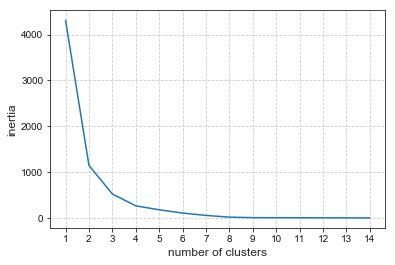

In [52]:
# Plot ks (x-axis) vs inertias (y-axis)
plt.plot(ks, inertias)
plt.xlabel('number of clusters', fontsize = 12)
plt.ylabel('inertia', fontsize = 12)
plt.xticks(np.arange(min(ks), max(ks) + 1, 1))
plt.show()

Looking at this plot `3` seems to be a good number of clusters as from this point onwards the inertia begin to decrease more slowly. So, let's try it.

In [53]:
n_clusters = 3

cluster_color_palette = sns.color_palette('Accent', n_clusters)
model_KMeans_cluster = KMeans(n_clusters = n_clusters, n_init = 50, max_iter = 1000)
model_KMeans_cluster.fit(df_cluster_KMeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=50, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [54]:
# assign the cluster labels to the dataframe
df_cluster['cluster'] = model_KMeans_cluster.labels_
df_cluster_KMeans['cluster'] = model_KMeans_cluster.labels_

C:\Users\Administrator.W1000590\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


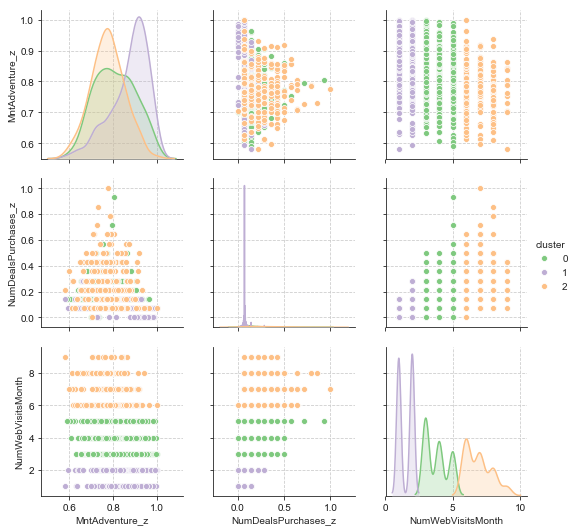

In [55]:
vars_clustering2_plot = ['MntAdventure_z', 'NumDealsPurchases_z', 'NumWebVisitsMonth']
fig_cluster = f_cluster_analysis(vars_clustering2_plot, df_cluster, cluster_color_palette)
plt.show(fig_cluster)

In [56]:
vars_centroids2 = ['MntAdventure_z', 'NumDealsPurchases_z', 'NumWebVisitsMonth']
centroids2 = pd.DataFrame(model_KMeans_cluster.cluster_centers_, columns = vars_clustering2)
centroids2

MntAdventure_z  NumDealsPurchases_z  NumWebVisitsMonth
0        0.809471             0.144377           3.808511
1        0.875272             0.073303           1.507289
2        0.776029             0.279094           6.917073

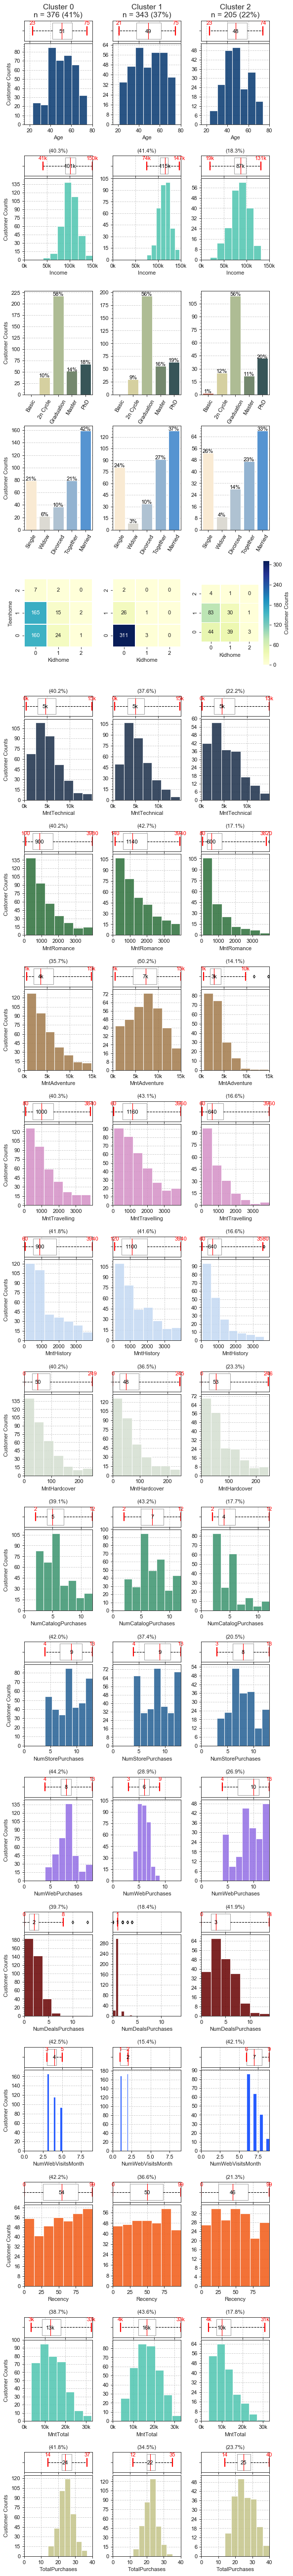

In [57]:
figClusterInt_cluster = f_cluster_interpretation(n_clusters, df_cluster)
plt.show(figClusterInt_cluster)

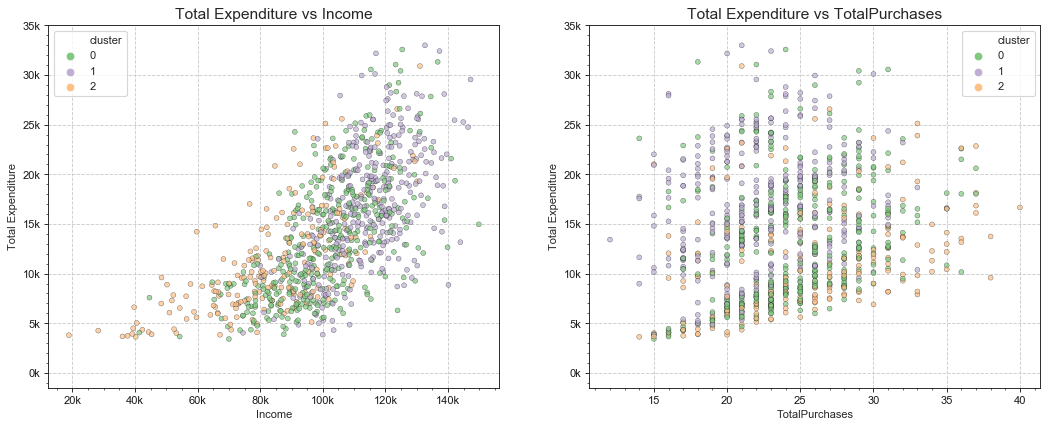

In [58]:
figClusterInt_xy_cluster = f_cluster_interpretation_xy(n_clusters, df_cluster, cluster_color_palette)
plt.show(figClusterInt_xy_cluster)

<a class="anchor" id="k_means_productusage-ki2"></a>
<b>Key Insights 2</b>:
   ><p><b>Wild and Free</b> (Cluster 37% n=343): They are wild because, comparatively to the other customers, they clearly buy more Adventure books but, at the same time, they also buy the other book types. They are free because typically don't have any children. This is the cluster with the higher median income (115k) and they are not very keen in looking for deals. These customers, they buy more books from the catalog and less from the web, comparatively with the other customers.</p>
   ><p><b>Price-conscious</b> (Cluster 22% n=205): This cluster is similar to the <b>Penny Pinchers</b> in the sense that they both have kids and/or teens at home, the recency is slightly lower, visit the site more often and they seem to be eager for deals. Nevertheless, the main difference between them is that the Price-Conscious customers buy, comparatively, less Adventure books, they have more income and, as a result, proportionally, the total expenditure is higher which, in the end, make them more interesting.</p> 
   ><p><b>General</b> (Cluster 41% n=376): This cluster represents the standard customers with any distinctive behavior. On most of the variables they trend close to the median. Nonetheless, it is a relevant cluster in terms of total purchases and total expenditure.</p>

In [59]:
# assign the labels to each cluster
dict_prodUsage_clusterLabel2 = {}
for idx, row in centroids2.iterrows():
    if(row['MntAdventure_z'] > .85):
        dict_prodUsage_clusterLabel2[idx] = 'Wild and Free'
    elif(row['NumWebVisitsMonth'] > 5):
        dict_prodUsage_clusterLabel2[idx] = 'Price-conscious'
    else:
        dict_prodUsage_clusterLabel2[idx] = 'General'

df_cluster.loc[:,'clusterStr'] = df_cluster['cluster'].map(lambda x: dict_prodUsage_clusterLabel2.get(x))

for idx, row in df_treated[df_treated['clusterProdUsage'] == 'Other'].iterrows():
    cluster_label = df_cluster.loc[df_cluster['Custid'] == row['Custid'], 'clusterStr'].values[0]
    df_treated.loc[idx, 'clusterProdUsage'] = cluster_label
dict_prodUsage_clusterLabel2

{0: 'General', 1: 'Wild and Free', 2: 'Price-conscious'}

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="k_means_customervalue"></a>
#### 4.1.2: Customer Value segmentation

In [60]:
df_productPurchases = df_treated.copy()

Variable selection:
<br>
<br>
`'NumDealsPurchases'`, `'MntTotal'`

In [61]:
### Create the dataframe for modelling
vars_clustering_value = ['TotalPurchases_z', 'MntTotal_z', 'Recency_z'] 

df_productPurchases_KMeans = df_productPurchases[vars_clustering_value].copy()
df_productPurchases_KMeans.head(n = 5)

TotalPurchases_z  MntTotal_z  Recency_z
0          0.666667    0.348717   0.101010
1          0.545455    0.612570   0.757576
2          0.000000    0.006224   0.313131
3          0.030303    0.013511   0.303030
4          0.030303    0.005465   0.373737

In [62]:
ks = range(1, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k, n_init = 50, precompute_distances = True, max_iter = 500)

    # Fit model to samples
    model.fit(df_productPurchases_KMeans)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

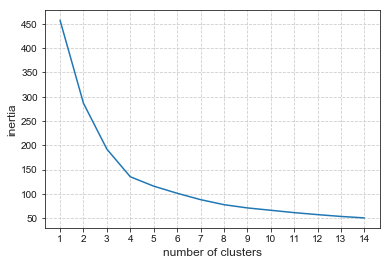

In [63]:
# Plot ks (x-axis) vs inertias (y-axis)
plt.plot(ks, inertias)
plt.xlabel('number of clusters', fontsize = 12)
plt.ylabel('inertia', fontsize = 12)
plt.xticks(np.arange(min(ks), max(ks) + 1, 1))
plt.show()

Looking at this plot `4` seems to be a good number of clusters as from this point onwards the inertia begin to decrease more slowly. So, let's try it.

In [64]:
n_clusters = 4
colors = ['#000075', '#bfef45', '#f58231', '#f032e6']
cluster_color_palette = sns.color_palette(colors)
model_KMeans_productPurchases = KMeans(n_clusters = n_clusters, n_init = 50, max_iter = 1000)
model_KMeans_productPurchases.fit(df_productPurchases_KMeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=4, n_init=50, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
# assign the cluster labels to the dataframe
df_productPurchases['cluster'] = model_KMeans_productPurchases.labels_
df_productPurchases_KMeans['cluster'] = model_KMeans_productPurchases.labels_

C:\Users\Administrator.W1000590\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


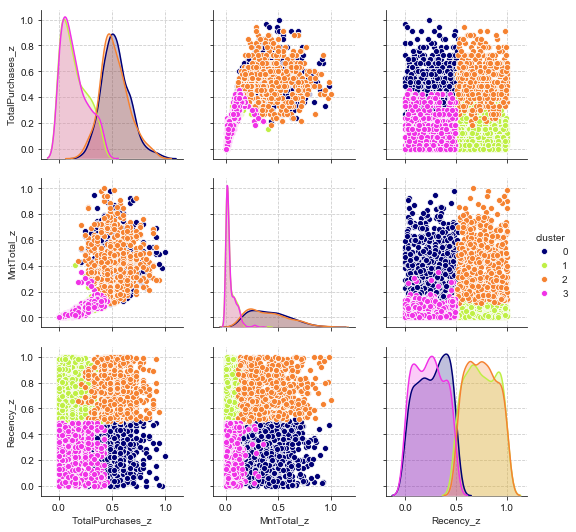

In [66]:
vars_clustering_plot = vars_clustering_value

fig_cluster_productPurchases = f_cluster_analysis(vars_clustering_plot, df_productPurchases, cluster_color_palette)
plt.show(fig_cluster_productPurchases)

In [67]:
centroids = pd.DataFrame(model_KMeans_productPurchases.cluster_centers_, columns = vars_clustering_value)
centroids

TotalPurchases_z  MntTotal_z  Recency_z
0          0.536722    0.416167   0.264688
1          0.148563    0.043844   0.746922
2          0.525253    0.404293   0.751344
3          0.149571    0.045014   0.234584

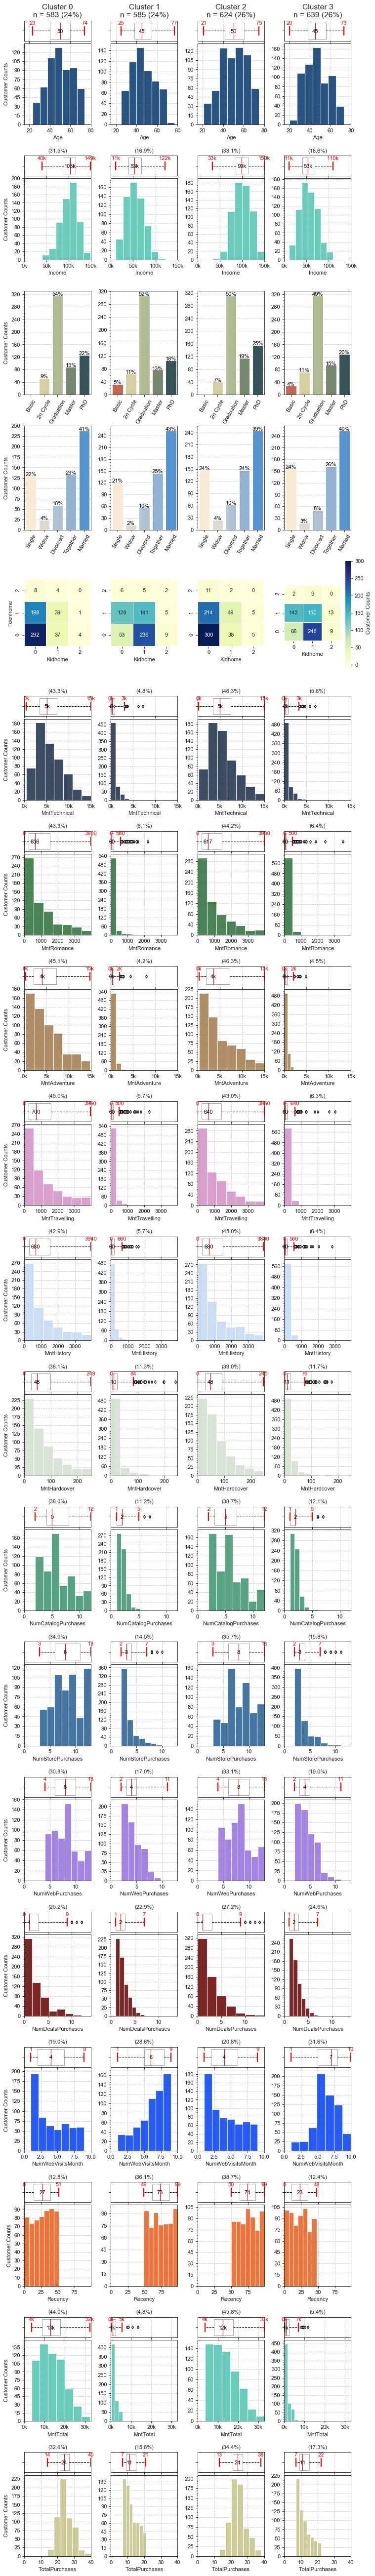

In [68]:
figClusterInt_productPurchases = f_cluster_interpretation(n_clusters, df_productPurchases)
plt.show(figClusterInt_productPurchases)

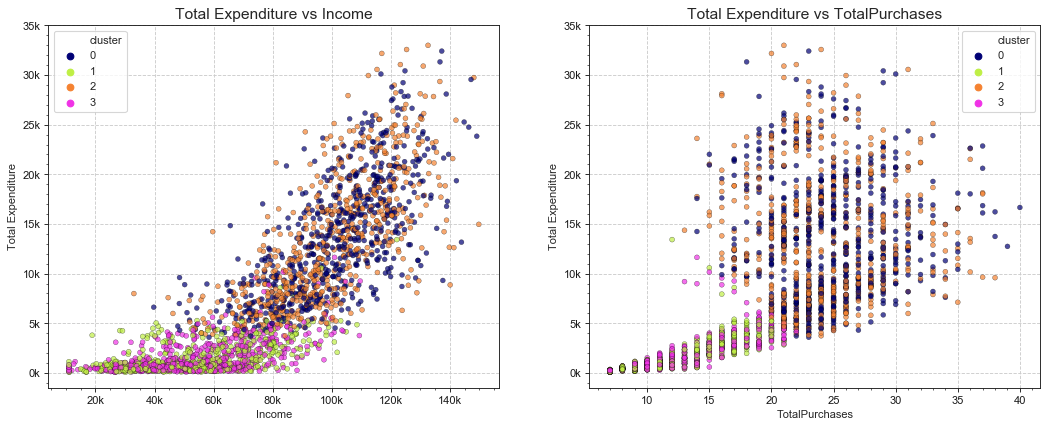

In [69]:
figClusterInt_xy_productPurchases = f_cluster_interpretation_xy(n_clusters, df_productPurchases, cluster_color_palette)
plt.show(figClusterInt_xy_productPurchases)

<a class="anchor" id="k_means_customervalue-ki"></a>
<b>Key Insights</b>:
   ><p> The 4 clusters are balanced in terms of the number of clusters (around 25% per cluster).</p>
   ><p> <b>Gold Frequent Buyers</b> (Cluster 24% n=583): This cluster has a low recency value less than 50 days and, at the same time, they have the higher income (median around 100k), which translates into more purchases (approx. 33%) and total expenditure (approx. 44%). Mostly they have 0 or 1 teen at home without kids and with the slightly higher median age.</p>
   ><p> <b>Gold Non-Frequent Buyers</b> (Cluster 26% n=624): This cluster has a high recency value above 50 days and, at the same time, they also have the higher income (median around 100k), which translates into more purchases (approx. 34%) and total expenditure (approx. 46%). Again, they mostly they have 0 or 1 teen at home without kids and with the slightly higher median age.</p>
   ><p> <b>Standard Frequent Buyers</b> (Cluster 26% n=639): This cluster has a low recency value less than 50 days, but it only represents a small fraction of the total purchases (approx. 17%) and even lower total expenditure (approx. 5%). They are the customers with a lower income (median around 50k) and with a lower education level (4% with a basic level of education). They usually have teens and/or kids at home, and with a slightly less median age.</p>
   ><p> <b>Standard Non-Frequent Buyers</b> (Cluster 24% n=585): This cluster has a high recency value above 50 days, and it also only represents a small fraction of the total purchases (approx. 16%) and even lower total expenditure (approx. 5%). They are the customers with a lower income (median around 50k) and with a lower education level (5% with a basic level of education). They usually have teens and/or kids at home, and with a slightly less median age.

In [70]:
# assign the labels to each cluster
dict_productPurchases_clusterLabel = {}
for idx, row in centroids.iterrows():
    if((row['TotalPurchases_z'] < .3) & (row['Recency_z'] < .5)):
        dict_productPurchases_clusterLabel[idx] = 'Standard Frequent Buyers'
    elif((row['TotalPurchases_z'] > .3) & (row['Recency_z'] > .5)):
        dict_productPurchases_clusterLabel[idx] = 'Gold Non-Frequent Buyers'
    elif((row['TotalPurchases_z'] > .3) & (row['Recency_z'] < .5)):
        dict_productPurchases_clusterLabel[idx] = 'Gold Frequent Buyers'
    else:
        dict_productPurchases_clusterLabel[idx] = 'Standard Non-Frequent Buyers'

df_productPurchases.loc[:,'clusterStr'] = df_productPurchases['cluster'].\
map(lambda x: dict_productPurchases_clusterLabel.get(x))
df_treated.loc[:,'clusterValue'] = df_productPurchases['clusterStr']
dict_productPurchases_clusterLabel

{0: 'Gold Frequent Buyers',
 1: 'Standard Non-Frequent Buyers',
 2: 'Gold Non-Frequent Buyers',
 3: 'Standard Frequent Buyers'}

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="remarks"></a>
### 4.2: Final Remarks

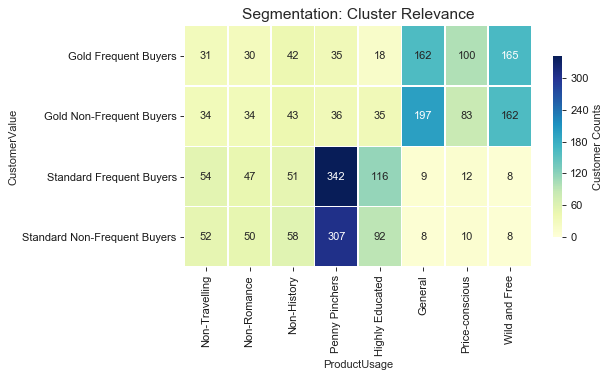

In [71]:
ProdUsage_list = ['Non-Travelling', 'Non-Romance', 'Non-History', 'Penny Pinchers', 'Highly Educated',\
                 'General', 'Price-conscious', 'Wild and Free']
CustomerValue_list = ['Standard Non-Frequent Buyers', 'Standard Frequent Buyers', 'Gold Non-Frequent Buyers', \
                     'Gold Frequent Buyers']

df_Segmentation = pd.DataFrame(np.zeros(shape = (len(CustomerValue_list), len(ProdUsage_list))))                          
for prod in range(len(ProdUsage_list)):
    for value in range(len(CustomerValue_list)):
        df_aux = df_treated[(df_treated['clusterProdUsage'] == ProdUsage_list[prod]) & \
                                                  (df_treated['clusterValue'] == CustomerValue_list[value])]
        
        df_Segmentation.iloc[value, prod] = df_aux.loc[:,'Custid'].count()
                                         
df_Segmentation

figSeg, axSeg = plt.subplots(figsize = (7, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
sns.heatmap(df_Segmentation,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = 0,\
                      vmax = df_Segmentation.values.max(), linewidths = .5,\
            cbar_kws = {'shrink': .75, 'label': 'Customer Counts'})\
.set_title('Segmentation: Cluster Relevance', size = 14)

axSeg.invert_yaxis()
axSeg.set_xlabel('ProductUsage')
axSeg.set_xticklabels(ProdUsage_list, **{'rotation': 90})
axSeg.set_ylabel('CustomerValue')
axSeg.set_yticklabels(CustomerValue_list, **{'rotation': 0})

plt.show(figSeg)

#### After a recognition phase, the marketer can realise what are the customers preferences, where they want to buy or even their loyalty to a company's products. We would like to give some tips to the marketing team: 
   * If the company needs to <b>empty the stock using deals</b>, their focus should be the <b>Standard Buyers</b> (frequent and non-frequent). Since it's easier to sell big volumes of items by Web, the <b>Penny Pinchers</b> would be the best choice. For those campaigns, it could be also interesting to include the <b>Price-conscious</b>;
   * If the marketing team wants to create a campaign with <b>only Adventure</b> books, they should, definitely, address their target to the <b>Wild and Free</b> customers. This group is constituted mainly by <b>Gold Buyers (frequent and non-frequent)</b>;
   * If the marketing team wants to create a campaign with <b>only Technical</b> books, they should address their target to <b>Gold Buyers (frequent and non-frequent)</b>, and it also should be interesting to include in that campaign the <b>Highly Educated</b> customers;
   * If the marketing team decides to create a campaign focused on selling by <b>Catalog</b>, they should address their target to <b>Gold Buyers (frequent and non-frequent)</b>.

[Return to Table of Contents](#Table_Contents)